# Titanic Prediction Model

First crack at a machine learning model. Aiming to predicit which passengers will survive the Titanic disaster.

## Summary
Best Test Score: 0.8219 

Test Name: CatBoost

Kaggle score 0.74162

## Overview

Exploratory Data Analysis
- Descriptive statistics, missing data, and column info type
- Feature Analysis
  - Relationships between features and target variable, surviving the Titanic

Data Cleansing - Cleaning any fields, and fitting them to the training and testing dataframes

Feature Engineering

Data Preprocessing

Model Building

In [109]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns # data visualization library
import missingno
import matplotlib.pyplot as plt
%matplotlib inline

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier,  Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier, Pool, cv
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Load in Datasets

In [2]:
# Import data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
gender = pd.read_csv('gender_submission.csv')

In [3]:
# View training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# View test data
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
# View gender data
# How we want our data to appear for submission
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [6]:
# Shape of datasets
print(f"Training dataset shape: {train.shape}")
print(f"Test dataset shape: {test.shape}")

Training dataset shape: (891, 12)
Test dataset shape: (418, 11)


#### Data Descriptions
To better understand what is meant by each column heading
- Survival: 0 = No, 1 = Yes

- Pclass(Ticket class): 1 = First, 2 = Second, 3 = Third

- Sex: Gender of the passenger

- Age: Age in years

- Sibsp: number of siblings/spouses aboard the Titanic

- Parch: number of parents/children aboard the Titanic

- Ticket: Ticket number

- Fare: Price paid for ticket

- Cabin: Cabin number

- Embarked: Port of Embarkment, C = Cherbourg, Q = Queenstown, S = Southampton

## Exploratory Data Analysis
The process of visualizing and analyzing data to extract insights.

### Data Types, Summary Statistics, and Missing data

In [7]:
# Dataset information
train.info()
print('-'*40)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
----------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Passenger

In [8]:
# Description of numeric data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [9]:
# Counts of missing data in train dataset
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [10]:
# Counts of missing data in test dataset
test.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

Text(0.5, 1.0, 'Trainning Missing Data')

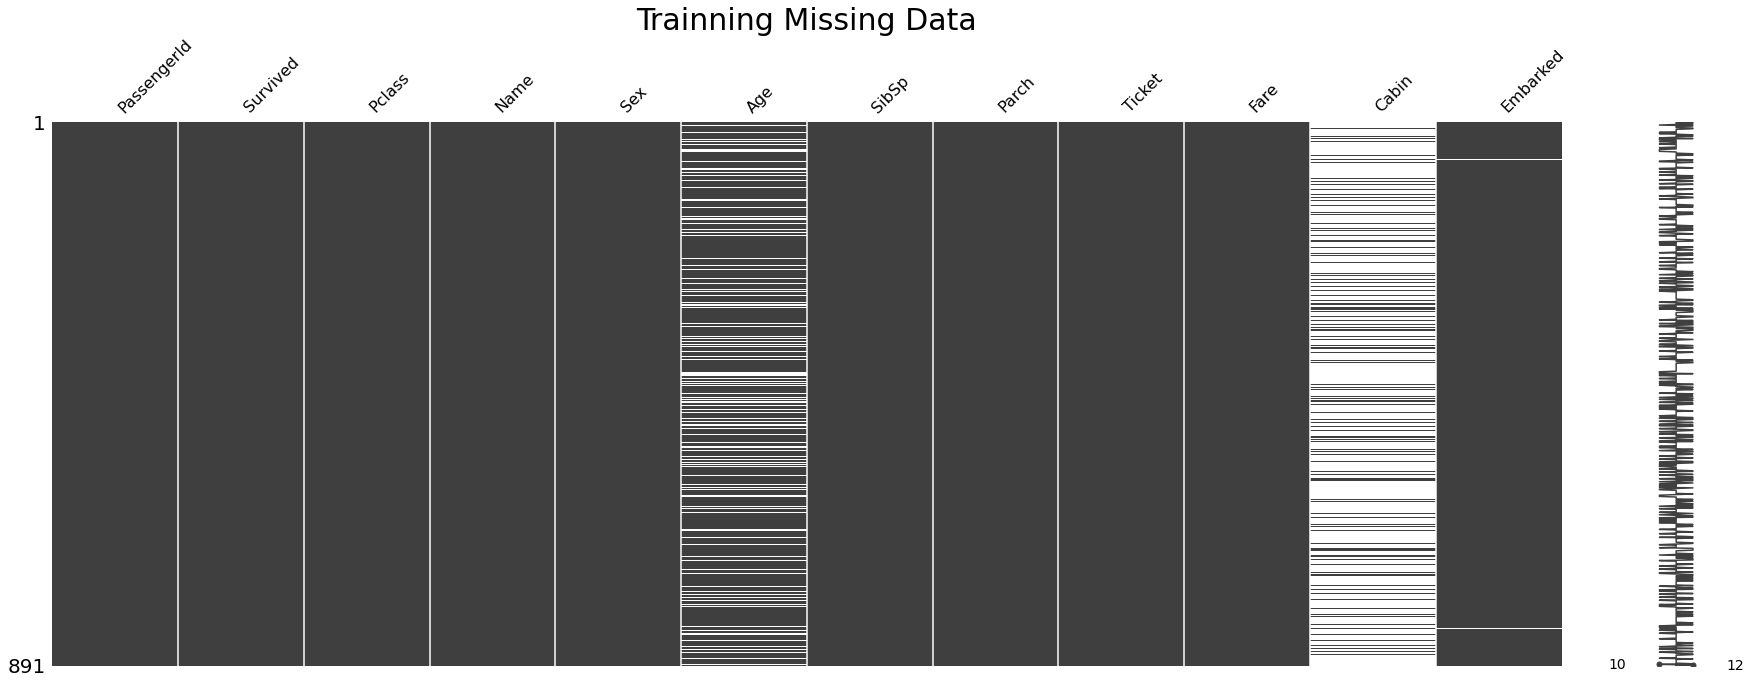

In [11]:
# Visual of missing data for train dataset
missingno.matrix(train, figsize = (30,10))
plt.title('Trainning Missing Data',fontsize=30)

Text(0.5, 1.0, 'Testing Missing Data')

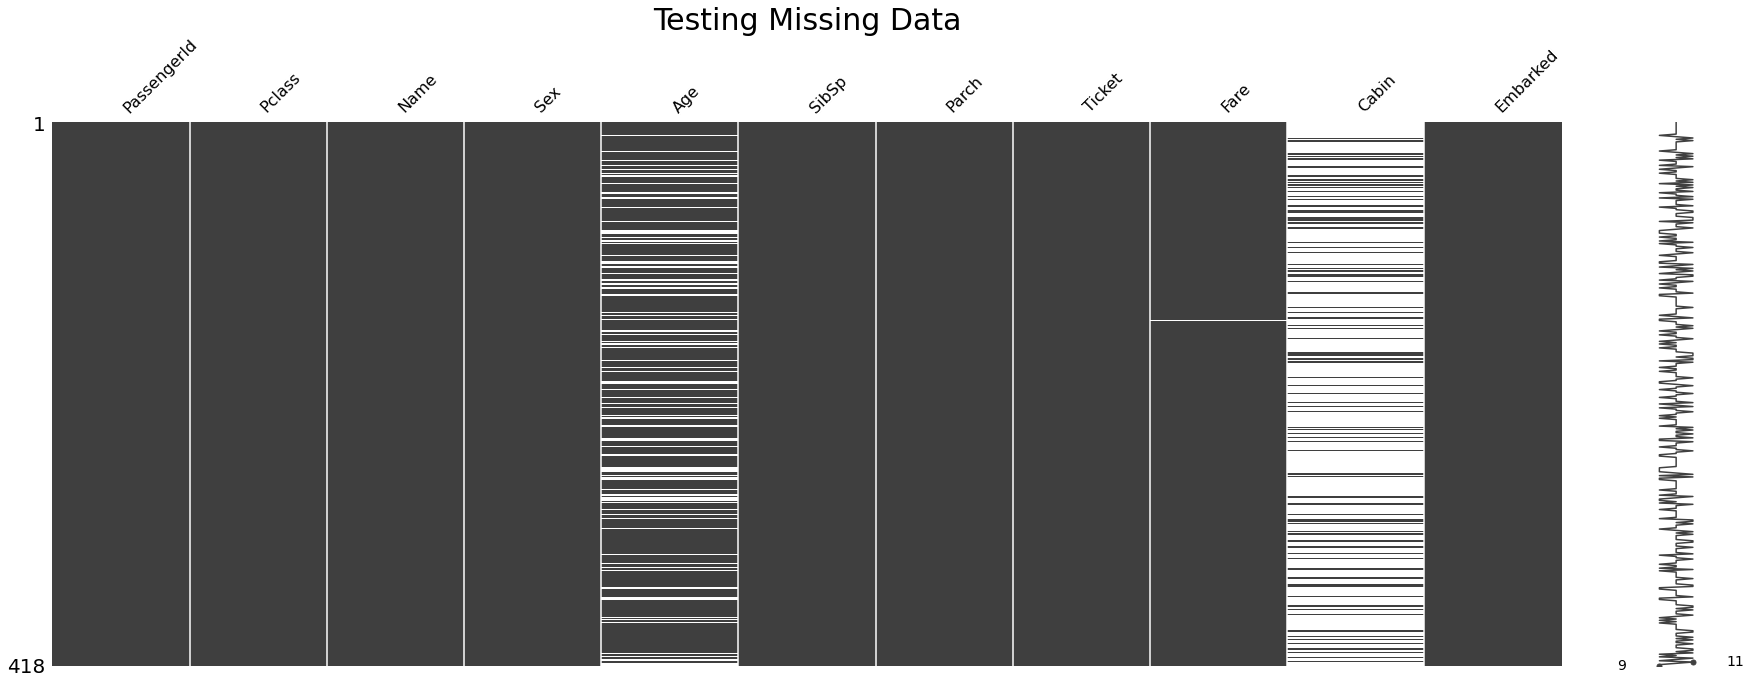

In [12]:
# Visual of missing data for test dataset
missingno.matrix(test, figsize = (30,10))
plt.title('Testing Missing Data',fontsize=30)

Based on this plot we can see that the cabin column has mostly missing values, making it very hard to work with.

Our age column is also missing some data, but we have a few optins to impute some data here to fill this column out. Additionally, Embarked column has 2 missing values, which is an easy fix.

### Feature Analysis
In the case study of the Titanic, we are looking to see how different attributes effect a passengers chance for surviving. To achieve this we will go through each column in the dataset to better understand this relationship.

#### Target Feature - Survived
Whether the passenger survived or not. This is the variable we want our model to predict.

Key: 0 = perished, 1 = survived

0    549
1    342
Name: Survived, dtype: int64


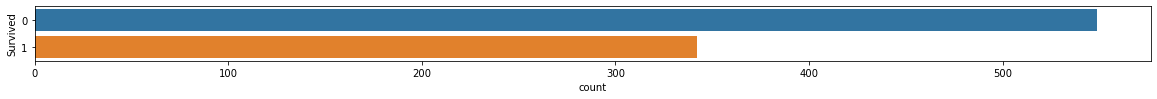

In [13]:
# Number of survivors
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Survived', data=train);
print('Value Counts:')
print(train['Survived'].value_counts())

#### Feature - Pclass
The ticket class of the passenger.

- Key: 1 = 1st, 2 = 2nd, 3 = 3rd

3    491
1    216
2    184
Name: Pclass, dtype: int64


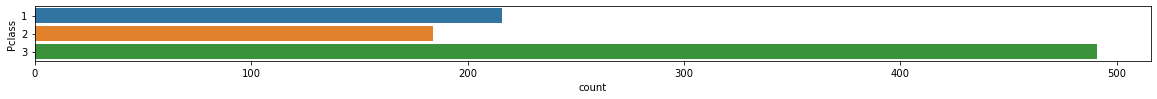

In [14]:
# View the data
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Pclass', data=train);
print('Value Counts:')
print(train['Pclass'].value_counts())

In [15]:
# Relationship with survivability
train[['Pclass','Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived',ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


Text(0, 0.5, 'Probablity of Surviving')

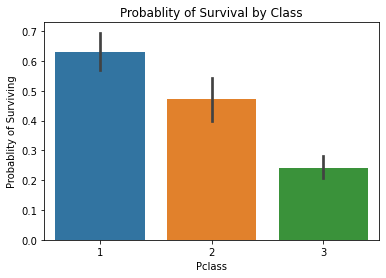

In [16]:
# Visualize the relationship
sns.barplot(x='Pclass',y='Survived',data=train)
plt.title('Probablity of Survival by Class')
plt.ylabel('Probablity of Surviving')

#### Observation
- As we can see from the table and plot above, those in better clases (ie. first class) had a higher chance of survival

#### Feature - Name

In [17]:
x = train['Name'].nunique()
y = len(train)
print(f'Number of unique names in the data {x}.\nNumber of rows in the data {y}.')

Number of unique names in the data 891.
Number of rows in the data 891.


From the above we can see that every entry in the Name field is a unique name. Catagorizing this will be harder. However later on we can create a new field, with the the name prefix (Mr., Mrs., Miss., etc...)

#### Feature - Sex
The sex of the passenger (male or female)

male      577
female    314
Name: Sex, dtype: int64


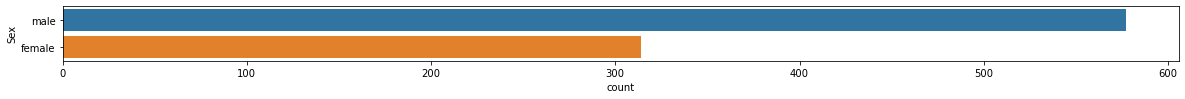

In [18]:
# View the data
fig = plt.figure(figsize=(20,1))
sns.countplot(y='Sex', data=train);
print('Value Counts:')
print(train['Sex'].value_counts())

In [19]:
# View the relationship between Sex and Surviving
train[['Sex','Survived']].groupby('Sex', as_index=False).mean().sort_values(by='Survived',ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


Text(0, 0.5, 'Probablity of Surviving')

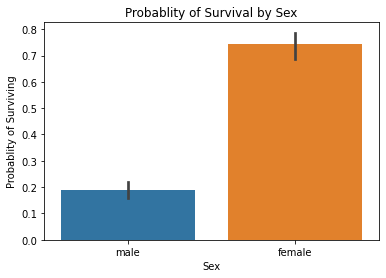

In [20]:
# Visualization of the relationship
sns.barplot(x='Sex',y='Survived',data=train)
plt.title('Probablity of Survival by Sex')
plt.ylabel('Probablity of Surviving')

#### Observation
- In the Titanic movie, when the ship is sinking we often hear "women and children first" the above plot and table really prove this point

#### Feature - Age
The age of the passenger

In [21]:
x = train['Age'].isnull().sum()
y = len(train)
z = ((x/y)*100)

print(f'There are {x} missing age entries, out of {y} rows, accounting for {z}% of the data')

There are 177 missing age entries, out of 891 rows, accounting for 19.865319865319865% of the data


Text(0.5, 1.0, 'Distribution of Passenger by Age')

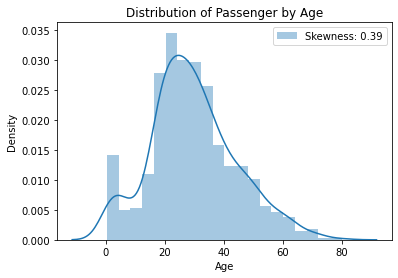

In [22]:
# View the distribution of the 'Age' field. 
# We won't bother with a pivot table at this point, as there are too many unique data points
sns.distplot(train['Age'], label = 'Skewness: %.2f'%(train['Age'].skew()));
plt.legend(loc = 'best')
plt.title('Distribution of Passenger by Age')

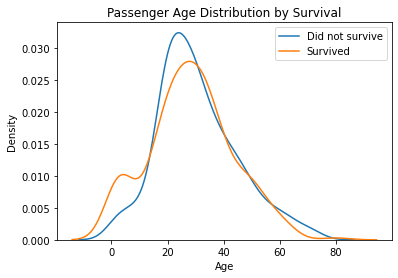

In [23]:
# Relationship between age and surviving
sns.kdeplot(train['Age'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Age'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Age')
plt.title('Passenger Age Distribution by Survival')
plt.legend()

#### Feature - SibSp
The number of siblings or spouses the passenger has onboard.


In [24]:
# Check for missing data
print(f"Number of missing values is: {train['SibSp'].isnull().sum()}")
# Value counts of SibSp
print('Value Counts:')
train['SibSp'].value_counts()

Number of missing values is: 0
Value Counts:


0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [25]:
# We can group the data by survived and number of siblings to help understand this data better
train[['SibSp','Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


Text(0, 0.5, 'Probablity of Surviving')

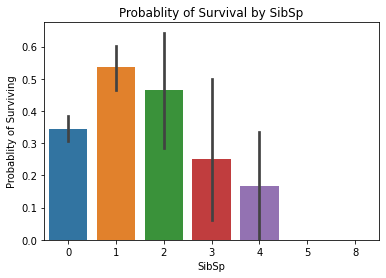

In [26]:
# Visualization of the relationship
sns.barplot(x='SibSp',y='Survived',data=train)
plt.title('Probablity of Survival by SibSp')
plt.ylabel('Probablity of Surviving')

We can see her that those with one sibling of spouse had the highest chance of survival.

#### Feature - Parch
The number of parents or children the passenger has on the Titanic.

This feature is very similar in nature to the SibSp, so we will handle it the same.

In [27]:
# Check for missing data
print(f"Number of missing values is: {train['Parch'].isnull().sum()}")
# Value counts of SibSp
print('Value Counts:')
train['Parch'].value_counts()

Number of missing values is: 0
Value Counts:


0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

#### Feature - Ticket
Ticket number of the boarding passenger.

In [28]:
# Check for missing data
print(f"There are {train['Ticket'].isnull().sum()} missing values for the Ticket field.")
# Check for unique values
print(f"There are {train['Ticket'].nunique()} unique enteries.")

There are 0 missing values for the Ticket field.
There are 681 unique enteries.


In [29]:
train['Ticket'].value_counts().head(10)

347082          7
1601            7
CA. 2343        7
CA 2144         6
347088          6
3101295         6
382652          5
S.O.C. 14879    5
17421           4
349909          4
Name: Ticket, dtype: int64

This field is too messy for our use case. There is most likely a way to simplify this column, but for a first attempt at this competition we will not use it. Perhaps in later attempts it will be more usefull.

#### Feature - Fare
Price paid by the passenger for their ticket.

In [30]:
# Again check for missing data
print(f"There are {train['Fare'].isnull().sum()} missing entries.")
# Check for number of unique enteries
print(f"There are {train['Fare'].nunique()} unique enteries.")

There are 0 missing entries.
There are 248 unique enteries.


Text(0.5, 1.0, 'Distribution of Passenger by Fare')

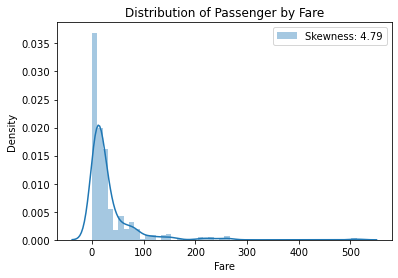

In [31]:
# View the distribution of the 'Age' field. 
# We won't bother with a pivot table at this point, as there are too many unique data points
sns.distplot(train['Fare'], label = 'Skewness: %.2f'%(train['Fare'].skew()));
plt.legend(loc = 'best')
plt.title('Distribution of Passenger by Fare')

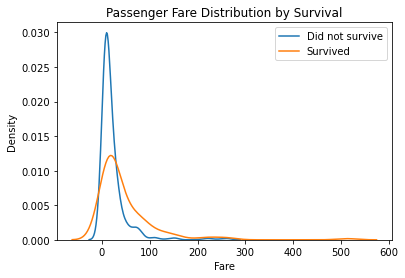

In [32]:
# Relationship between Fare and surviving
sns.kdeplot(train['Fare'][train['Survived'] == 0], label = 'Did not survive')
sns.kdeplot(train['Fare'][train['Survived'] == 1], label = 'Survived')
plt.xlabel('Fare')
plt.title('Passenger Fare Distribution by Survival')
plt.legend()

#### Observation
- The 'Fare' column has a high degree of skewness. In order for this to be usable in our model we will have to perform a log transformation on the data
- Additionally, in order to add this to our model we will want to bin the data

#### Feature - Cabin
Cabin number the passenger stayed in.

In [33]:
# Check for missing data
print(f"There are {train['Cabin'].isnull().sum()} missing values.")
# Unique enteries
print(f"There are {train['Cabin'].nunique()} unique values.")
# Percentage
print(f"The missing data accounts for {(train['Cabin'].isnull().sum()/len(train)*100)}% of values")

There are 687 missing values.
There are 147 unique values.
The missing data accounts for 77.10437710437711% of values


In [34]:
# View data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


#### Observation
- With 77% of the data missing, using this feature in our model will be problematic. While there may exist a method to impute the missing data here, for a first run we will omit this field

#### Feature - Embarked
Where the passenger boarded the Titanic

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [35]:
# Check for missing data
print(f"There are {train['Embarked'].isnull().sum()} missing values.")
# Check the distribution
print('Value Counts:')
train['Embarked'].value_counts()

There are 2 missing values.
Value Counts:


S    644
C    168
Q     77
Name: Embarked, dtype: int64

Text(0.5, 1.0, 'Passenger Count by Embarked Location')

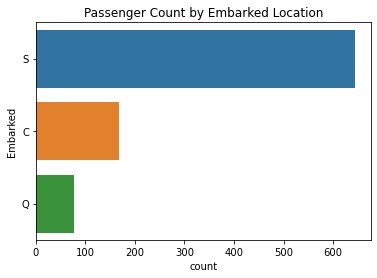

In [36]:
# Visualize
sns.countplot(y='Embarked',data=train)
plt.title('Passenger Count by Embarked Location')

Text(0, 0.5, 'Probablity of Surviving')

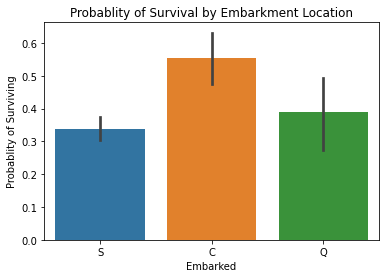

In [37]:
sns.barplot(x='Embarked',y='Survived',data=train)
plt.title('Probablity of Survival by Embarkment Location')
plt.ylabel('Probablity of Surviving')

#### Observation
- While the majority of passengers boarded at Southampton, it was those who embarked at Cherbourg how had the best chance of survival
- With only two missing entries for this feature, we will replace them with the most common embarkment location, Southampton

## Relationships Between Multiple Features and Surviving

When looking at the data we have found out some key indicators of passengers who survived. We are also able to combine some of these features to help get a fuller picture of those who survived.

### Passenger Class and Sex
From the common knowledge of the event, and from film, we know that saving women and children's lives' was prioritized. To better understand just which women and children were saved we can further examine the relationhip between gender, class, and survivors 

Text(0.5, 1.0, 'Survival Probability by Sex and Passenger Class')

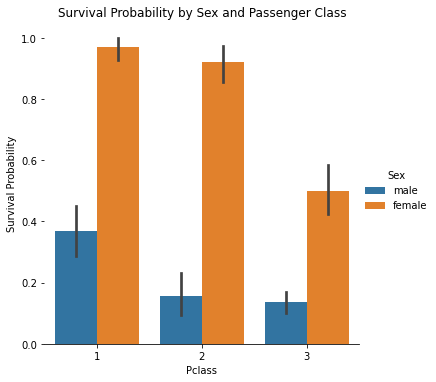

In [38]:
# Survival by gender and passenger class
gender_class_sur = sns.factorplot(x = 'Pclass', y = 'Survived', hue = 'Sex', data = train, kind = 'bar')
gender_class_sur.despine(left = True)
plt.ylabel('Survival Probability')
plt.title('Survival Probability by Sex and Passenger Class')

#### Observation
- By combining these two features we can see the effect that being first or second class, as well as being female had on your survival rate 

### Embarkment by Class Type
By looking deeper into where a passenger boarded and their class we can further determine thier chance for survival

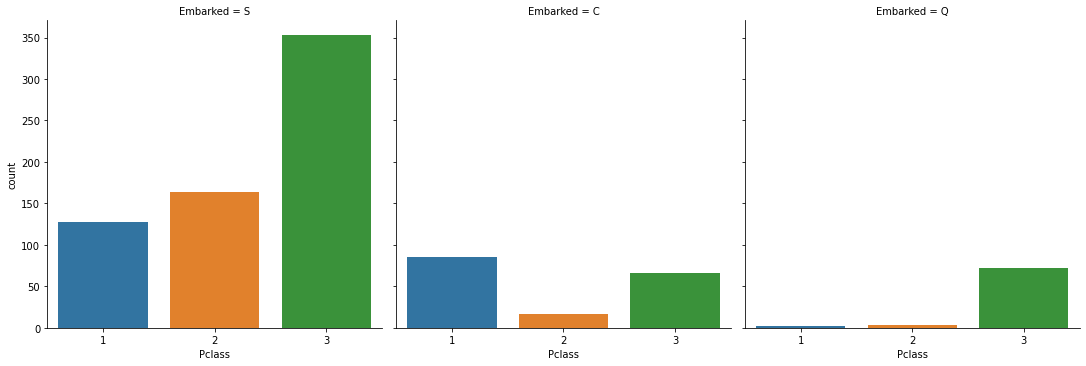

In [39]:
sns.factorplot('Pclass', col = 'Embarked', data = train, kind = 'count')

### Correlations Between Numerical Features and Survivability

<AxesSubplot:>

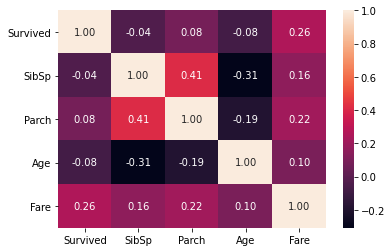

In [40]:
sns.heatmap(train[['Survived', 'SibSp', 'Parch', 'Age', 'Fare']].corr(), annot = True, fmt = '.2f')

#### Observation
- After visualizing the correlation the numeric columns have with survivng, it become clear that the 'Fare' feature has the stongest correlation. This comes as no suprise as we have seen above, those in higher classes had a much higher chance of survival

## Data Preprocessing
Now that we have completed the initial data exploration, we can start to prepare the features for our model. To accomplish this we will perfom a few tasks:
- Drop features
- Replace missing values
- Data transformation

### Drop Features
As we have previously noted, the Cabin feature and Ticket have either too many missing data points or in their current state are too complicated for our analysis 

In [41]:
# Drop both columns from both dataframe
train = train.drop(['Cabin','Ticket'], axis=1)
test = test.drop(['Cabin','Ticket'], axis=1)

### Impute Missing Data

In [42]:
print('Train missing data:')
print(train.isnull().sum())
print('-'*20)
print('Test missing data:')
print(test.isnull().sum())

Train missing data:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Fare             0
Embarked         2
dtype: int64
--------------------
Test missing data:
PassengerId     0
Pclass          0
Name            0
Sex             0
Age            86
SibSp           0
Parch           0
Fare            1
Embarked        0
dtype: int64


In [43]:
# Train - Embarkment
# Only the train dataset has missing data for this column, as previously mentioned we will replace it with the most common value
mode = train['Embarked'].mode()[0]
print(f"Replacing missing values with '{mode}'.")
train['Embarked'].fillna(mode, inplace = True)

Replacing missing values with 'S'.


In [44]:
# Test - Fare
mode = test['Fare'].mode()[0]
print(f"Replacing missing value with '{mode}'.")
test['Fare'].fillna(mode, inplace=True)

Replacing missing value with '7.75'.


#### Combine Datasets
At this point we can combine our train and test datasets. In doing so we will be able to impute the missing values for the 'Age' feature more accurately.

In [45]:
combined = pd.concat([train,test], axis=0).reset_index(drop=True)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


In [46]:
# Missing values for 'Age'
combined.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age            263
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

Text(0.5, 1.0, 'Distribution of Passenger by Age')

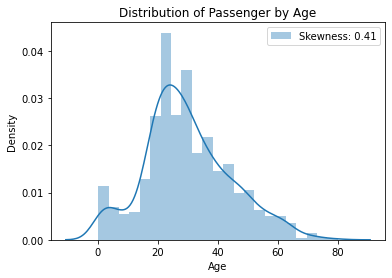

In [47]:
sns.distplot(combined['Age'], label = 'Skewness: %.2f'%(combined['Age'].skew()));
plt.legend(loc = 'best')
plt.title('Distribution of Passenger by Age')

In [48]:
# Missing data and unique entries
print(f"There are {combined['Age'].isnull().sum()} missing data points.")
print(f"And there are {combined['Age'].nunique()} unique entries.")

There are 263 missing data points.
And there are 98 unique entries.


In [49]:
# Create a variable to house the index number of missing age
age_nan_indices = list(combined[combined['Age'].isnull()].index)
len(age_nan_indices)

263

In [50]:
# Loop through list and impute missing ages

for index in age_nan_indices:
    median_age = combined['Age'].median()
    predict_age = combined['Age'][(combined['SibSp'] == combined.iloc[index]['SibSp']) 
                                 & (combined['Parch'] == combined.iloc[index]['Parch'])
                                 & (combined['Pclass'] == combined.iloc[index]["Pclass"])].median()
    if np.isnan(predict_age):
        combined['Age'].iloc[index] = median_age
    else:
        combined['Age'].iloc[index] = predict_age

In [51]:
# Confirm that all nan values have been replaced
combined['Age'].isnull().sum()

0

Text(0.5, 1.0, 'Distribution of Passenger by Age(After imputing missing data)')

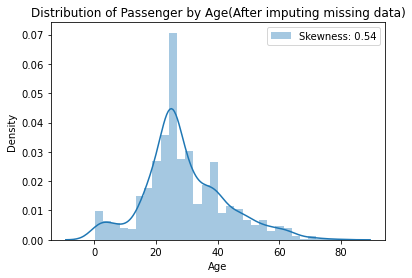

In [52]:
# View the distribution of 'Age' again
sns.distplot(combined['Age'], label = 'Skewness: %.2f'%(combined['Age'].skew()));
plt.legend(loc = 'best')
plt.title('Distribution of Passenger by Age(After imputing missing data)')

In [53]:
combined['Sex'] = combined['Sex'].map({'male': 0, 'female': 1})

Text(0.5, 1.0, 'Distribution of SibSp by Sex')

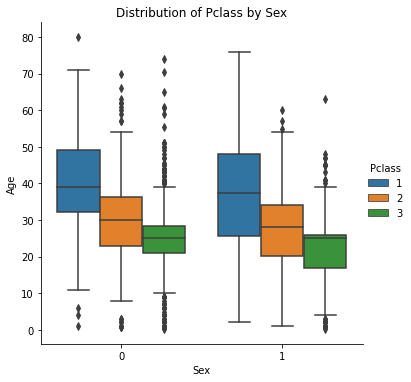

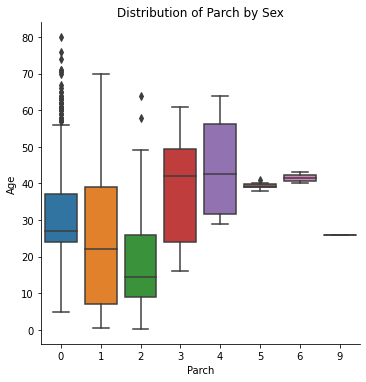

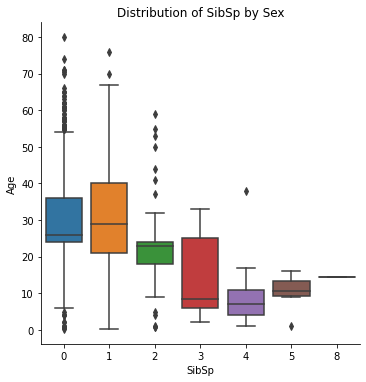

In [54]:
sns.factorplot(y = 'Age', x = 'Sex', hue = 'Pclass', kind = 'box', data = combined)
plt.title('Distribution of Pclass by Sex')
sns.factorplot(y = 'Age', x = 'Parch', kind = 'box', data = combined)
plt.title('Distribution of Parch by Sex')
sns.factorplot(y = 'Age', x = 'SibSp', kind = 'box', data = combined)
plt.title('Distribution of SibSp by Sex')

<AxesSubplot:>

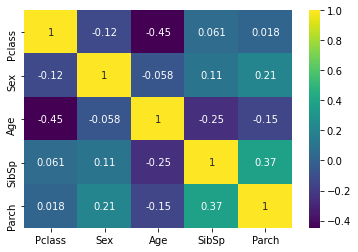

In [55]:
# Plot of correlation between numeric features and surviving
sns.heatmap(combined.drop(['Survived', 'Name', 'PassengerId', 'Fare'], axis = 1).corr(), annot = True, cmap='viridis')

In [56]:
# Check our combined dataset again for any missing values
# We see that survived is missing 418 entries, but that is alright as finding those values is the purpose of buiding this model
combined.isnull().sum()

PassengerId      0
Survived       418
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Fare             0
Embarked         0
dtype: int64

## Feature Engineering
The purpose of feature engineering is to create new columns from exisiting data

#### Feature - Name

In [57]:
# Create a new column housing the name prefix
combined['NamePrefix'] = train['Name'].apply(lambda x: x.split(',')[1].split('.')[0].strip())

In [58]:
# View new column
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,NamePrefix
0,1,0.0,3,"Braund, Mr. Owen Harris",0,22.0,1,0,7.2500,S,Mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.0,1,0,71.2833,C,Mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",1,26.0,0,0,7.9250,S,Miss
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.0,1,0,53.1000,S,Mrs
4,5,0.0,3,"Allen, Mr. William Henry",0,35.0,0,0,8.0500,S,Mr


In [59]:
# View value counts for newly created column
combined['NamePrefix'].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Lady              1
Ms                1
Mme               1
the Countess      1
Don               1
Jonkheer          1
Sir               1
Capt              1
Name: NamePrefix, dtype: int64

In [60]:
# Variables to consolidate NamePrefix
Miss = ('Ms','Melle','Lady','Mme','Mlle')
Rare = ('Dr','Rev','Don','Jonkheer','Major','Col','Sir','the Countess','Capt')

In [61]:
# Check number of unique nameprefix, perform replacement, and check unique numer again
print(f"Number of unique NamePrefix {combined['NamePrefix'].nunique()}.")
combined['NamePrefix'].replace(Miss,'Miss',inplace=True)
combined['NamePrefix'].replace(Rare,'Rare',inplace=True)
print(f"New number of unique NamePrefix {combined['NamePrefix'].nunique()}.")

Number of unique NamePrefix 17.
New number of unique NamePrefix 5.


In [62]:
# View the number of each nameprefix
combined['NamePrefix'].value_counts()

Mr        517
Miss      187
Mrs       125
Master     40
Rare       22
Name: NamePrefix, dtype: int64

Text(0, 0.5, 'Probablity of Surviving')

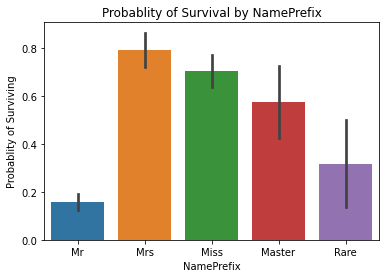

In [63]:
# View the relationship between Nameprefix and Surviving
sns.barplot(x='NamePrefix',y='Survived',data=combined)
plt.title('Probablity of Survival by NamePrefix')
plt.ylabel('Probablity of Surviving')

In [64]:
# Drop the 'Name' feature from our dataset
combined.drop(labels='Name',axis=1,inplace=True)

In [65]:
# View coombined dataset
combined.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NamePrefix
0,1,0.0,3,0,22.0,1,0,7.2500,S,Mr
1,2,1.0,1,1,38.0,1,0,71.2833,C,Mrs
2,3,1.0,3,1,26.0,0,0,7.9250,S,Miss
3,4,1.0,1,1,35.0,1,0,53.1000,S,Mrs
4,5,0.0,3,0,35.0,0,0,8.0500,S,Mr


#### Feature - IsAlone
- Create a simplified feature indicating if a passenger was travelling with family or alone

In [66]:
# Calculate the family size
combined['FamilySize'] = combined['SibSp'] + combined['Parch'] + 1
combined[['SibSp', 'Parch', 'FamilySize']].head()

,SibSp,Parch,FamilySize
0,1,0,2
1,1,0,2
2,0,0,1
3,1,0,2
4,0,0,1


In [67]:
# Create a feature if they are alone
combined['IsAlone'] = 0
combined.loc[combined['FamilySize'] == 1, 'IsAlone'] = 1

#### Feature - AgeClass
- As we have seen above those passengers who were wealthy and older had a better chance of survival. We want to make sure this comes across in our model, so we will create a feature multiplying age by class
- Before we can create this feature, we must bin the values for 'Age' this will tranform the data into ordinal values

In [68]:
# Create age bands and compute mean of survival by age bands
combined['AgeBin'] = pd.cut(combined['Age'], 5)
combined[['AgeBin', 'Survived']].groupby('AgeBin', as_index=False).mean().sort_values(by = 'AgeBin')

,AgeBin,Survived
0,"(0.0902, 16.136]",0.500000
1,"(16.136, 32.102]",0.341719
2,"(32.102, 48.068]",0.412844
3,"(48.068, 64.034]",0.434783
4,"(64.034, 80.0]",0.090909


In [69]:
# Now that we have the 'Age' feature in bins, we can assign ordinal values to each
combined.loc[combined['Age'] <= 16.136, 'Age'] = 0
combined.loc[(combined['Age'] > 16.136) & (combined['Age'] <= 32.102), 'Age'] = 1
combined.loc[(combined['Age'] > 32.102) & (combined['Age'] <= 48.068), 'Age'] = 2
combined.loc[(combined['Age'] > 48.068) & (combined['Age'] <= 64.034), 'Age'] = 3
combined.loc[combined['Age'] > 64.034 , 'Age'] = 4

In [70]:
# Convert ordinal 'Age' into integer for easier calculation
combined['Age'] = combined['Age'].astype('int')
combined['Age'].dtype

dtype('int64')

In [71]:
# Create the 'AgeClass' feature
combined['AgeClass'] = combined['Age'] * combined['Pclass']
combined.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,NamePrefix,FamilySize,IsAlone,AgeBin,AgeClass
0,1,0.0,3,0,1,1,0,7.2500,S,Mr,2,0,"(16.136, 32.102]",3
1,2,1.0,1,1,2,1,0,71.2833,C,Mrs,2,0,"(32.102, 48.068]",2
2,3,1.0,3,1,1,0,0,7.9250,S,Miss,1,1,"(16.136, 32.102]",3
3,4,1.0,1,1,2,1,0,53.1000,S,Mrs,2,0,"(32.102, 48.068]",2
4,5,0.0,3,0,2,0,0,8.0500,S,Mr,1,1,"(32.102, 48.068]",6


In [72]:
# Let's also remove some unnecessary features
combined.drop(labels=['SibSp','Parch','FamilySize','AgeBin'],axis=1,inplace=True)

In [73]:
# View the data set
combined.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,NamePrefix,IsAlone,AgeClass
0,1,0.0,3,0,1,7.2500,S,Mr,0,3
1,2,1.0,1,1,2,71.2833,C,Mrs,0,2
2,3,1.0,3,1,1,7.9250,S,Miss,1,3
3,4,1.0,1,1,2,53.1000,S,Mrs,0,2
4,5,0.0,3,0,2,8.0500,S,Mr,1,6


### Data Transformation

Text(0.5, 1.0, 'Distribution of Fare')

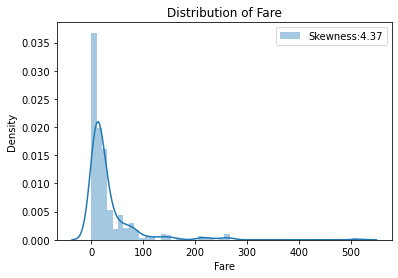

In [74]:
sns.distplot(combined['Fare'], label ='Skewness:%.2f'%(combined['Fare'].skew()))
plt.legend(loc='best')
plt.title('Distribution of Fare')

Observing our distribution of the Fare feature we can see that it has a strong right skew. In order to adress this issue we are going to perform a log transformation. This will help to normalize the data.

In [75]:
# Perform log transformation
combined['Fare'] = combined['Fare'].map(lambda x: np.log(x) if x > 0 else 0)

Text(0.5, 1.0, 'Distribution of Fare (Post Log Transformation)')

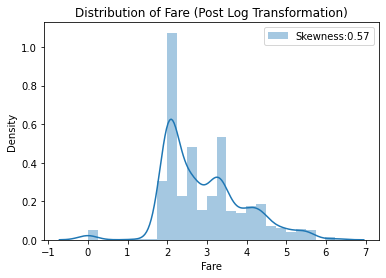

In [76]:
# View data again
sns.distplot(combined['Fare'], label ='Skewness:%.2f'%(combined['Fare'].skew()))
plt.legend(loc='best')
plt.title('Distribution of Fare (Post Log Transformation)')

#### Observation 
- As we can see form the second plot, our data is more evenly distributed and we have reduced the skewness

## Feature Encoding
For machine learning models to work all input and output variables must be numeric. Through the process of feature encoding, we will convert necessary columns to numeric.

In [77]:
# View data set
combined.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,NamePrefix,IsAlone,AgeClass
0,1,0.0,3,0,1,1.981001,S,Mr,0,3
1,2,1.0,1,1,2,4.266662,C,Mrs,0,2
2,3,1.0,3,1,1,2.070022,S,Miss,1,3
3,4,1.0,1,1,2,3.972177,S,Mrs,0,2
4,5,0.0,3,0,2,2.085672,S,Mr,1,6


In [78]:
# Convert 'Sex' to numeric
#combined['Sex'] = combined['Sex'].map({'male': 0, 'female': 1})

In [79]:
# Title and Embakred column
combined = pd.get_dummies(combined, columns = ['NamePrefix'])
combined = pd.get_dummies(combined, columns = ['Embarked'], prefix = 'Em')
combined.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,AgeClass,NamePrefix_Master,NamePrefix_Miss,NamePrefix_Mr,NamePrefix_Mrs,NamePrefix_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1.981001,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,4.266662,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,2.070022,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,3.972177,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,2.085672,1,6,0,0,1,0,0,0,0,1


In [80]:
# Bin 'Fare' into 4 groups
combined['FareBand'] = pd.cut(combined['Fare'], 4)
combined[['FareBand', 'Survived']].groupby(['FareBand'], as_index=False).mean().sort_values(by = 'FareBand')

,FareBand,Survived
0,"(-0.00624, 1.56]",0.062500
1,"(1.56, 3.119]",0.288719
2,"(3.119, 4.679]",0.504983
3,"(4.679, 6.239]",0.745098


In [81]:
# Convert the 'Fare' feature into ordinals based on our 'FareBand'
combined.loc[combined['Fare'] <=1.56,'Fare'] = 0
combined.loc[(combined['Fare'] > 1.56)&(combined['Fare'] <=3.119),'Fare'] = 1
combined.loc[(combined['Fare'] > 3.119)&(combined['Fare'] <=4.679),'Fare'] = 2
combined.loc[combined['Fare'] >6.239,'Fare'] = 3
combined['Fare'] = combined['Fare'].astype(int)

In [82]:
# Remove 'FareBand' feature
combined.drop(labels='FareBand',axis=1,inplace=True)

In [83]:
combined.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,AgeClass,NamePrefix_Master,NamePrefix_Miss,NamePrefix_Mr,NamePrefix_Mrs,NamePrefix_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,3,1.0,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,4,1.0,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,5,0.0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [84]:
# Separate training and test set from the combined dataframe
train = combined[:len(train)]
test = combined[len(train):]

In [85]:
train.head(2)

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,AgeClass,NamePrefix_Master,NamePrefix_Miss,NamePrefix_Mr,NamePrefix_Mrs,NamePrefix_Rare,Em_C,Em_Q,Em_S
0,1,0.0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,2,1.0,1,1,2,2,0,2,0,0,0,1,0,1,0,0


In [86]:
test.head(2)

,PassengerId,Survived,Pclass,Sex,Age,Fare,IsAlone,AgeClass,NamePrefix_Master,NamePrefix_Miss,NamePrefix_Mr,NamePrefix_Mrs,NamePrefix_Rare,Em_C,Em_Q,Em_S
891,892,NaN,3,0,2,1,1,6,0,0,0,0,0,0,1,0
892,893,NaN,3,1,2,1,0,6,0,0,0,0,0,0,0,1


In [87]:
# Train
# Drop pass id in train
# convert survived to int

# Test
# Drop survived

In [88]:
# Train dataset
# Drop 'PassengerId' column
# Convert 'Survived' to int
train.drop(labels='PassengerId',axis=1,inplace=True)
train['Survived'] = train['Survived'].astype(int)

In [89]:
# Test Dataset
# Drop survived feature
test.drop(labels='Survived',axis=1,inplace=True)

In [90]:
train.head()

,Survived,Pclass,Sex,Age,Fare,IsAlone,AgeClass,NamePrefix_Master,NamePrefix_Miss,NamePrefix_Mr,NamePrefix_Mrs,NamePrefix_Rare,Em_C,Em_Q,Em_S
0,0,3,0,1,1,0,3,0,0,1,0,0,0,0,1
1,1,1,1,2,2,0,2,0,0,0,1,0,1,0,0
2,1,3,1,1,1,1,3,0,1,0,0,0,0,0,1
3,1,1,1,2,2,0,2,0,0,0,1,0,0,0,1
4,0,3,0,2,1,1,6,0,0,1,0,0,0,0,1


In [91]:
test.head()

,PassengerId,Pclass,Sex,Age,Fare,IsAlone,AgeClass,NamePrefix_Master,NamePrefix_Miss,NamePrefix_Mr,NamePrefix_Mrs,NamePrefix_Rare,Em_C,Em_Q,Em_S
891,892,3,0,2,1,1,6,0,0,0,0,0,0,1,0
892,893,3,1,2,1,0,6,0,0,0,0,0,0,0,1
893,894,2,0,3,1,1,6,0,0,0,0,0,0,1,0
894,895,3,0,1,1,1,3,0,0,0,0,0,0,0,1
895,896,3,1,1,1,0,3,0,0,0,0,0,0,0,1


## Split Datasets
Now that we have our data in the proper format we can split up or data fro our training and testing purposes.

To being, we will first split our data into indpeendent variables (predictor variables), represented by X, and dependent variables represented by Y.

For our example, Y_train is the survived column from our train dataset, and X-train is the other columns. Our models will learn to classify survival(Y_train) based on all X_train and make predictions on X_test.

In [92]:
# Split data
Y_train = train['Survived']
X_train = train.drop(labels='Survived',axis=1)
X_test = test.drop(labels='PassengerId',axis=1).copy()
print(f"Y_train shape {Y_train.shape}")
print(f"X_train shape {X_train.shape}")
print(f"X_test shape {X_test.shape}")

Y_train shape (891,)
X_train shape (891, 14)
X_test shape (418, 14)


## Modeling
Now that our data is processed and split into training and testing sets we can begin constructing our models.

The Titanic problem is a classification example, we will be using classification models from scikit-learn. The following are the models we will use:
- Logistic Regression
- Support Vector Machines
- K-Nearest Neighbours
- Gaussian naive bayes
- Perceptron
- Linear SVC
- Stochastic gradient descent
- Decision tree
- Random forest
- CatBoost

This process requires 3 simple steps: 
- Instantiate the model, 
- Fit the model to the training set 
- Predict the data in test set.

### Logistic Regression

In [93]:
# Logistic Regression model
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
print(f"Score: {acc_log}")

Score: 82.49


### Support Vector Machines

In [104]:
# SVM
svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, Y_train) * 100, 2)
print(f"Score: {acc_svc}")

Score: 82.72


### K-Nearest Neighbours

In [95]:
# KNN
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, Y_train) * 100, 2)
print(f"Score: {acc_knn}")

Score: 84.51


### Gaussian naive bayes

In [96]:
# Gaussian 
gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, Y_train) * 100, 2)
print(f"Score: {acc_gaussian}")

Score: 78.34


### Perceptron

In [106]:
# Perceptron
perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_train, Y_train) * 100, 2)
print(f"Score: {acc_perceptron}")

Score: 81.26


### Linear SVC

In [107]:
# Linear SVC
linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_train, Y_train) * 100, 2)
acc_linear_svc

82.04

### Stochastic Gradient Descent

In [108]:
# Stochastic Gradient Descent
sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_train, Y_train) * 100, 2)
acc_sgd

75.2

### Decision Tree

In [98]:
# Decision Tree
decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_train, Y_train) * 100, 2)
print(f"Score: {acc_decision_tree}")

Score: 86.08


### Random Forest

In [110]:
# Random Forest
random_forest = RandomForestClassifier(n_estimators = 100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
acc_random_forest = round(random_forest.score(X_train, Y_train) * 100, 2)
acc_random_forest

86.08

### CatBoost

In [100]:
catboost = CatBoostClassifier()
catboost.fit(X_train, Y_train)
Y_pred = catboost.predict(X_test)
acc_catboost = round(catboost.score(X_train, Y_train) * 100, 2)

Learning rate set to 0.009807
0:	learn: 0.6866068	total: 57.3ms	remaining: 57.2s
1:	learn: 0.6803861	total: 59.5ms	remaining: 29.7s
2:	learn: 0.6733213	total: 61.4ms	remaining: 20.4s
3:	learn: 0.6672936	total: 63.2ms	remaining: 15.7s
4:	learn: 0.6610454	total: 65.1ms	remaining: 13s
5:	learn: 0.6556891	total: 67.2ms	remaining: 11.1s
6:	learn: 0.6502234	total: 69.3ms	remaining: 9.84s
7:	learn: 0.6440869	total: 71.3ms	remaining: 8.84s
8:	learn: 0.6390332	total: 72.9ms	remaining: 8.03s
9:	learn: 0.6336706	total: 74.7ms	remaining: 7.39s
10:	learn: 0.6288788	total: 76.4ms	remaining: 6.87s
11:	learn: 0.6249955	total: 78ms	remaining: 6.42s
12:	learn: 0.6193686	total: 79.8ms	remaining: 6.06s
13:	learn: 0.6150673	total: 81.1ms	remaining: 5.71s
14:	learn: 0.6095664	total: 82.6ms	remaining: 5.42s
15:	learn: 0.6043532	total: 83.9ms	remaining: 5.16s
16:	learn: 0.6000430	total: 85ms	remaining: 4.92s
17:	learn: 0.5949605	total: 86.5ms	remaining: 4.72s
18:	learn: 0.5903944	total: 88.3ms	remaining: 4.56

217:	learn: 0.3765523	total: 498ms	remaining: 1.78s
218:	learn: 0.3763629	total: 501ms	remaining: 1.79s
219:	learn: 0.3760816	total: 503ms	remaining: 1.78s
220:	learn: 0.3758493	total: 510ms	remaining: 1.8s
221:	learn: 0.3756575	total: 514ms	remaining: 1.8s
222:	learn: 0.3755972	total: 516ms	remaining: 1.8s
223:	learn: 0.3754704	total: 518ms	remaining: 1.8s
224:	learn: 0.3753492	total: 521ms	remaining: 1.79s
225:	learn: 0.3750731	total: 522ms	remaining: 1.79s
226:	learn: 0.3749934	total: 524ms	remaining: 1.78s
227:	learn: 0.3748314	total: 526ms	remaining: 1.78s
228:	learn: 0.3745829	total: 528ms	remaining: 1.78s
229:	learn: 0.3742467	total: 530ms	remaining: 1.77s
230:	learn: 0.3740754	total: 532ms	remaining: 1.77s
231:	learn: 0.3739963	total: 534ms	remaining: 1.77s
232:	learn: 0.3736941	total: 535ms	remaining: 1.76s
233:	learn: 0.3735044	total: 537ms	remaining: 1.76s
234:	learn: 0.3732567	total: 538ms	remaining: 1.75s
235:	learn: 0.3731446	total: 540ms	remaining: 1.75s
236:	learn: 0.37

388:	learn: 0.3571963	total: 837ms	remaining: 1.31s
389:	learn: 0.3571116	total: 840ms	remaining: 1.31s
390:	learn: 0.3570399	total: 842ms	remaining: 1.31s
391:	learn: 0.3569678	total: 844ms	remaining: 1.31s
392:	learn: 0.3568713	total: 846ms	remaining: 1.31s
393:	learn: 0.3568101	total: 849ms	remaining: 1.3s
394:	learn: 0.3567224	total: 851ms	remaining: 1.3s
395:	learn: 0.3566883	total: 855ms	remaining: 1.3s
396:	learn: 0.3565960	total: 857ms	remaining: 1.3s
397:	learn: 0.3565047	total: 859ms	remaining: 1.3s
398:	learn: 0.3563405	total: 861ms	remaining: 1.3s
399:	learn: 0.3562912	total: 863ms	remaining: 1.29s
400:	learn: 0.3562363	total: 865ms	remaining: 1.29s
401:	learn: 0.3561771	total: 874ms	remaining: 1.3s
402:	learn: 0.3560978	total: 877ms	remaining: 1.3s
403:	learn: 0.3560703	total: 878ms	remaining: 1.29s
404:	learn: 0.3560157	total: 880ms	remaining: 1.29s
405:	learn: 0.3559648	total: 882ms	remaining: 1.29s
406:	learn: 0.3559037	total: 884ms	remaining: 1.29s
407:	learn: 0.355837

552:	learn: 0.3472273	total: 1.18s	remaining: 950ms
553:	learn: 0.3471615	total: 1.19s	remaining: 957ms
554:	learn: 0.3470707	total: 1.19s	remaining: 954ms
555:	learn: 0.3470348	total: 1.19s	remaining: 951ms
556:	learn: 0.3469785	total: 1.19s	remaining: 949ms
557:	learn: 0.3469522	total: 1.2s	remaining: 947ms
558:	learn: 0.3468975	total: 1.2s	remaining: 944ms
559:	learn: 0.3468770	total: 1.2s	remaining: 942ms
560:	learn: 0.3468567	total: 1.2s	remaining: 939ms
561:	learn: 0.3468461	total: 1.2s	remaining: 936ms
562:	learn: 0.3468065	total: 1.2s	remaining: 934ms
563:	learn: 0.3467474	total: 1.21s	remaining: 932ms
564:	learn: 0.3466693	total: 1.21s	remaining: 929ms
565:	learn: 0.3466249	total: 1.21s	remaining: 927ms
566:	learn: 0.3465467	total: 1.21s	remaining: 924ms
567:	learn: 0.3464614	total: 1.21s	remaining: 922ms
568:	learn: 0.3464584	total: 1.21s	remaining: 919ms
569:	learn: 0.3463928	total: 1.21s	remaining: 916ms
570:	learn: 0.3463901	total: 1.22s	remaining: 913ms
571:	learn: 0.3463

711:	learn: 0.3399996	total: 1.47s	remaining: 596ms
712:	learn: 0.3399307	total: 1.48s	remaining: 594ms
713:	learn: 0.3399041	total: 1.48s	remaining: 592ms
714:	learn: 0.3398918	total: 1.48s	remaining: 590ms
715:	learn: 0.3398632	total: 1.48s	remaining: 588ms
716:	learn: 0.3398489	total: 1.48s	remaining: 586ms
717:	learn: 0.3398255	total: 1.49s	remaining: 583ms
718:	learn: 0.3398009	total: 1.49s	remaining: 581ms
719:	learn: 0.3397441	total: 1.49s	remaining: 579ms
720:	learn: 0.3396885	total: 1.49s	remaining: 577ms
721:	learn: 0.3396070	total: 1.49s	remaining: 575ms
722:	learn: 0.3395718	total: 1.5s	remaining: 573ms
723:	learn: 0.3395456	total: 1.5s	remaining: 571ms
724:	learn: 0.3395261	total: 1.5s	remaining: 569ms
725:	learn: 0.3394708	total: 1.5s	remaining: 566ms
726:	learn: 0.3394285	total: 1.5s	remaining: 564ms
727:	learn: 0.3394036	total: 1.5s	remaining: 562ms
728:	learn: 0.3393780	total: 1.5s	remaining: 560ms
729:	learn: 0.3393117	total: 1.51s	remaining: 558ms
730:	learn: 0.33923

890:	learn: 0.3327322	total: 1.81s	remaining: 221ms
891:	learn: 0.3327054	total: 1.81s	remaining: 219ms
892:	learn: 0.3326658	total: 1.81s	remaining: 217ms
893:	learn: 0.3326378	total: 1.81s	remaining: 215ms
894:	learn: 0.3326095	total: 1.82s	remaining: 213ms
895:	learn: 0.3325498	total: 1.82s	remaining: 211ms
896:	learn: 0.3325234	total: 1.82s	remaining: 209ms
897:	learn: 0.3325052	total: 1.82s	remaining: 207ms
898:	learn: 0.3324714	total: 1.83s	remaining: 205ms
899:	learn: 0.3324390	total: 1.83s	remaining: 203ms
900:	learn: 0.3324031	total: 1.83s	remaining: 201ms
901:	learn: 0.3323788	total: 1.83s	remaining: 199ms
902:	learn: 0.3323577	total: 1.83s	remaining: 197ms
903:	learn: 0.3323340	total: 1.83s	remaining: 195ms
904:	learn: 0.3323056	total: 1.83s	remaining: 193ms
905:	learn: 0.3322844	total: 1.84s	remaining: 191ms
906:	learn: 0.3322500	total: 1.84s	remaining: 189ms
907:	learn: 0.3321971	total: 1.84s	remaining: 187ms
908:	learn: 0.3321452	total: 1.84s	remaining: 185ms
909:	learn: 

In [101]:
acc_catboost

85.97

## Model Evaluation

### Training Accuracy
How well has the model learned from the training set

In [111]:
models = pd.DataFrame({'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
                                 'Random Forest', 'Naive Bayes', 'Perceptron', 'Stochastic Gradient Decent', 
                                 'Linear SVC', 'Decision Tree', 'CatBoost'],
                       'Score': [acc_svc, acc_knn, acc_log, acc_random_forest, acc_gaussian, acc_perceptron,
                                 acc_sgd, acc_linear_svc, acc_decision_tree, acc_catboost]})

models.sort_values(by = 'Score', ascending = False, ignore_index = True)

,Model,Score
0,Random Forest,86.08
1,Decision Tree,86.08
2,CatBoost,85.97
3,KNN,84.51
4,Support Vector Machines,82.72
5,Logistic Regression,82.49
6,Linear SVC,82.04
7,Perceptron,81.26
8,Naive Bayes,78.34
9,Stochastic Gradient Decent,75.20


In [112]:
# Create a list which contains classifiers 

classifiers = []
classifiers.append(LogisticRegression())
classifiers.append(SVC())
classifiers.append(KNeighborsClassifier(n_neighbors = 5))
classifiers.append(GaussianNB())
classifiers.append(Perceptron())
classifiers.append(LinearSVC())
classifiers.append(SGDClassifier())
classifiers.append(DecisionTreeClassifier())
classifiers.append(RandomForestClassifier())
classifiers.append(CatBoostClassifier())

len(classifiers)

10

In [113]:
# Create a list which contains cross validation results for each classifier

cv_results = []
for classifier in classifiers:
    cv_results.append(cross_val_score(classifier, X_train, Y_train, scoring = 'accuracy', cv = 10))

Learning rate set to 0.009371
0:	learn: 0.6868464	total: 1.97ms	remaining: 1.96s
1:	learn: 0.6807771	total: 3.64ms	remaining: 1.82s
2:	learn: 0.6746015	total: 5.33ms	remaining: 1.77s
3:	learn: 0.6686260	total: 6.99ms	remaining: 1.74s
4:	learn: 0.6624823	total: 8.68ms	remaining: 1.73s
5:	learn: 0.6573547	total: 10.5ms	remaining: 1.74s
6:	learn: 0.6517308	total: 11.9ms	remaining: 1.68s
7:	learn: 0.6453665	total: 13.3ms	remaining: 1.64s
8:	learn: 0.6403923	total: 14.3ms	remaining: 1.57s
9:	learn: 0.6357243	total: 15.6ms	remaining: 1.55s
10:	learn: 0.6314809	total: 16.9ms	remaining: 1.52s
11:	learn: 0.6277319	total: 18.2ms	remaining: 1.5s
12:	learn: 0.6221057	total: 19.5ms	remaining: 1.48s
13:	learn: 0.6178498	total: 20.5ms	remaining: 1.45s
14:	learn: 0.6123627	total: 22ms	remaining: 1.45s
15:	learn: 0.6072022	total: 23.7ms	remaining: 1.46s
16:	learn: 0.6029360	total: 25ms	remaining: 1.45s
17:	learn: 0.5979085	total: 26.8ms	remaining: 1.46s
18:	learn: 0.5936558	total: 28.4ms	remaining: 1.4

198:	learn: 0.3764586	total: 338ms	remaining: 1.36s
199:	learn: 0.3762684	total: 341ms	remaining: 1.36s
200:	learn: 0.3758711	total: 343ms	remaining: 1.36s
201:	learn: 0.3757617	total: 347ms	remaining: 1.37s
202:	learn: 0.3753519	total: 349ms	remaining: 1.37s
203:	learn: 0.3751203	total: 350ms	remaining: 1.37s
204:	learn: 0.3749675	total: 352ms	remaining: 1.36s
205:	learn: 0.3749226	total: 353ms	remaining: 1.36s
206:	learn: 0.3746186	total: 354ms	remaining: 1.36s
207:	learn: 0.3744035	total: 356ms	remaining: 1.35s
208:	learn: 0.3743719	total: 357ms	remaining: 1.35s
209:	learn: 0.3740971	total: 358ms	remaining: 1.35s
210:	learn: 0.3738053	total: 360ms	remaining: 1.34s
211:	learn: 0.3737726	total: 362ms	remaining: 1.34s
212:	learn: 0.3734378	total: 364ms	remaining: 1.34s
213:	learn: 0.3730928	total: 365ms	remaining: 1.34s
214:	learn: 0.3729022	total: 366ms	remaining: 1.34s
215:	learn: 0.3727026	total: 367ms	remaining: 1.33s
216:	learn: 0.3725214	total: 369ms	remaining: 1.33s
217:	learn: 

393:	learn: 0.3497111	total: 675ms	remaining: 1.04s
394:	learn: 0.3496030	total: 678ms	remaining: 1.04s
395:	learn: 0.3494836	total: 680ms	remaining: 1.04s
396:	learn: 0.3493690	total: 682ms	remaining: 1.03s
397:	learn: 0.3492090	total: 683ms	remaining: 1.03s
398:	learn: 0.3491855	total: 684ms	remaining: 1.03s
399:	learn: 0.3491513	total: 685ms	remaining: 1.03s
400:	learn: 0.3490906	total: 687ms	remaining: 1.02s
401:	learn: 0.3490357	total: 688ms	remaining: 1.02s
402:	learn: 0.3490342	total: 689ms	remaining: 1.02s
403:	learn: 0.3488682	total: 690ms	remaining: 1.02s
404:	learn: 0.3487433	total: 691ms	remaining: 1.01s
405:	learn: 0.3486466	total: 695ms	remaining: 1.02s
406:	learn: 0.3486126	total: 696ms	remaining: 1.01s
407:	learn: 0.3486049	total: 697ms	remaining: 1.01s
408:	learn: 0.3485920	total: 699ms	remaining: 1.01s
409:	learn: 0.3485093	total: 701ms	remaining: 1.01s
410:	learn: 0.3484269	total: 703ms	remaining: 1.01s
411:	learn: 0.3483991	total: 704ms	remaining: 1s
412:	learn: 0.3

602:	learn: 0.3363167	total: 1.02s	remaining: 670ms
603:	learn: 0.3362349	total: 1.02s	remaining: 668ms
604:	learn: 0.3361751	total: 1.02s	remaining: 667ms
605:	learn: 0.3361358	total: 1.02s	remaining: 665ms
606:	learn: 0.3360804	total: 1.02s	remaining: 663ms
607:	learn: 0.3360798	total: 1.02s	remaining: 661ms
608:	learn: 0.3360006	total: 1.03s	remaining: 660ms
609:	learn: 0.3359763	total: 1.03s	remaining: 658ms
610:	learn: 0.3359267	total: 1.03s	remaining: 656ms
611:	learn: 0.3358580	total: 1.03s	remaining: 654ms
612:	learn: 0.3358358	total: 1.03s	remaining: 653ms
613:	learn: 0.3358028	total: 1.03s	remaining: 651ms
614:	learn: 0.3357644	total: 1.04s	remaining: 650ms
615:	learn: 0.3357330	total: 1.04s	remaining: 648ms
616:	learn: 0.3356460	total: 1.04s	remaining: 647ms
617:	learn: 0.3356400	total: 1.04s	remaining: 645ms
618:	learn: 0.3355874	total: 1.04s	remaining: 643ms
619:	learn: 0.3355607	total: 1.05s	remaining: 641ms
620:	learn: 0.3355574	total: 1.05s	remaining: 640ms
621:	learn: 

798:	learn: 0.3264054	total: 1.35s	remaining: 339ms
799:	learn: 0.3263745	total: 1.35s	remaining: 338ms
800:	learn: 0.3263028	total: 1.35s	remaining: 336ms
801:	learn: 0.3262264	total: 1.35s	remaining: 334ms
802:	learn: 0.3261821	total: 1.35s	remaining: 332ms
803:	learn: 0.3261105	total: 1.35s	remaining: 330ms
804:	learn: 0.3261105	total: 1.35s	remaining: 328ms
805:	learn: 0.3260575	total: 1.36s	remaining: 327ms
806:	learn: 0.3260549	total: 1.36s	remaining: 325ms
807:	learn: 0.3260154	total: 1.36s	remaining: 324ms
808:	learn: 0.3259811	total: 1.36s	remaining: 322ms
809:	learn: 0.3258968	total: 1.36s	remaining: 320ms
810:	learn: 0.3258443	total: 1.37s	remaining: 319ms
811:	learn: 0.3258408	total: 1.37s	remaining: 317ms
812:	learn: 0.3258207	total: 1.37s	remaining: 315ms
813:	learn: 0.3257814	total: 1.37s	remaining: 314ms
814:	learn: 0.3257639	total: 1.38s	remaining: 312ms
815:	learn: 0.3256922	total: 1.38s	remaining: 311ms
816:	learn: 0.3256067	total: 1.38s	remaining: 309ms
817:	learn: 

996:	learn: 0.3180138	total: 1.68s	remaining: 5.05ms
997:	learn: 0.3179767	total: 1.68s	remaining: 3.37ms
998:	learn: 0.3179313	total: 1.69s	remaining: 1.69ms
999:	learn: 0.3179011	total: 1.69s	remaining: 0us
Learning rate set to 0.009376
0:	learn: 0.6869249	total: 1.89ms	remaining: 1.89s
1:	learn: 0.6810315	total: 3.27ms	remaining: 1.63s
2:	learn: 0.6749843	total: 16.6ms	remaining: 5.53s
3:	learn: 0.6689030	total: 19.1ms	remaining: 4.74s
4:	learn: 0.6634623	total: 22.4ms	remaining: 4.45s
5:	learn: 0.6583167	total: 24.3ms	remaining: 4.02s
6:	learn: 0.6530127	total: 26.6ms	remaining: 3.77s
7:	learn: 0.6470209	total: 30.5ms	remaining: 3.79s
8:	learn: 0.6432989	total: 31.9ms	remaining: 3.52s
9:	learn: 0.6387395	total: 33.9ms	remaining: 3.35s
10:	learn: 0.6340279	total: 35.5ms	remaining: 3.19s
11:	learn: 0.6292972	total: 36.9ms	remaining: 3.04s
12:	learn: 0.6246565	total: 39.6ms	remaining: 3s
13:	learn: 0.6194278	total: 41.4ms	remaining: 2.92s
14:	learn: 0.6146938	total: 44ms	remaining: 2.

181:	learn: 0.3915106	total: 322ms	remaining: 1.45s
182:	learn: 0.3914238	total: 325ms	remaining: 1.45s
183:	learn: 0.3912174	total: 327ms	remaining: 1.45s
184:	learn: 0.3907886	total: 329ms	remaining: 1.45s
185:	learn: 0.3903861	total: 331ms	remaining: 1.45s
186:	learn: 0.3901550	total: 333ms	remaining: 1.45s
187:	learn: 0.3896764	total: 335ms	remaining: 1.45s
188:	learn: 0.3894415	total: 337ms	remaining: 1.45s
189:	learn: 0.3891567	total: 339ms	remaining: 1.44s
190:	learn: 0.3888835	total: 341ms	remaining: 1.44s
191:	learn: 0.3888263	total: 342ms	remaining: 1.44s
192:	learn: 0.3886476	total: 344ms	remaining: 1.44s
193:	learn: 0.3884025	total: 348ms	remaining: 1.45s
194:	learn: 0.3882300	total: 349ms	remaining: 1.44s
195:	learn: 0.3880234	total: 350ms	remaining: 1.44s
196:	learn: 0.3878340	total: 351ms	remaining: 1.43s
197:	learn: 0.3873910	total: 352ms	remaining: 1.43s
198:	learn: 0.3872080	total: 354ms	remaining: 1.42s
199:	learn: 0.3868776	total: 356ms	remaining: 1.42s
200:	learn: 

376:	learn: 0.3624481	total: 654ms	remaining: 1.08s
377:	learn: 0.3623540	total: 657ms	remaining: 1.08s
378:	learn: 0.3621904	total: 658ms	remaining: 1.08s
379:	learn: 0.3621517	total: 660ms	remaining: 1.08s
380:	learn: 0.3621024	total: 662ms	remaining: 1.07s
381:	learn: 0.3620542	total: 664ms	remaining: 1.07s
382:	learn: 0.3619818	total: 666ms	remaining: 1.07s
383:	learn: 0.3619095	total: 668ms	remaining: 1.07s
384:	learn: 0.3617750	total: 670ms	remaining: 1.07s
385:	learn: 0.3617125	total: 671ms	remaining: 1.07s
386:	learn: 0.3615973	total: 673ms	remaining: 1.07s
387:	learn: 0.3615381	total: 675ms	remaining: 1.06s
388:	learn: 0.3615042	total: 678ms	remaining: 1.06s
389:	learn: 0.3614502	total: 680ms	remaining: 1.06s
390:	learn: 0.3614027	total: 681ms	remaining: 1.06s
391:	learn: 0.3613221	total: 682ms	remaining: 1.06s
392:	learn: 0.3612470	total: 684ms	remaining: 1.05s
393:	learn: 0.3610847	total: 685ms	remaining: 1.05s
394:	learn: 0.3609461	total: 686ms	remaining: 1.05s
395:	learn: 

572:	learn: 0.3494050	total: 979ms	remaining: 730ms
573:	learn: 0.3493764	total: 981ms	remaining: 728ms
574:	learn: 0.3493277	total: 984ms	remaining: 727ms
575:	learn: 0.3492206	total: 985ms	remaining: 725ms
576:	learn: 0.3491893	total: 987ms	remaining: 724ms
577:	learn: 0.3491703	total: 989ms	remaining: 722ms
578:	learn: 0.3491410	total: 991ms	remaining: 720ms
579:	learn: 0.3491110	total: 993ms	remaining: 719ms
580:	learn: 0.3490743	total: 995ms	remaining: 717ms
581:	learn: 0.3490303	total: 997ms	remaining: 716ms
582:	learn: 0.3490289	total: 998ms	remaining: 714ms
583:	learn: 0.3489338	total: 1000ms	remaining: 712ms
584:	learn: 0.3488536	total: 1s	remaining: 710ms
585:	learn: 0.3488323	total: 1s	remaining: 708ms
586:	learn: 0.3487715	total: 1s	remaining: 706ms
587:	learn: 0.3486969	total: 1s	remaining: 704ms
588:	learn: 0.3485808	total: 1.01s	remaining: 703ms
589:	learn: 0.3485222	total: 1.01s	remaining: 701ms
590:	learn: 0.3484985	total: 1.01s	remaining: 700ms
591:	learn: 0.3484695	t

771:	learn: 0.3397376	total: 1.31s	remaining: 388ms
772:	learn: 0.3396772	total: 1.32s	remaining: 387ms
773:	learn: 0.3396184	total: 1.32s	remaining: 386ms
774:	learn: 0.3395956	total: 1.32s	remaining: 384ms
775:	learn: 0.3395376	total: 1.32s	remaining: 382ms
776:	learn: 0.3395144	total: 1.33s	remaining: 381ms
777:	learn: 0.3394673	total: 1.33s	remaining: 379ms
778:	learn: 0.3394420	total: 1.33s	remaining: 378ms
779:	learn: 0.3393224	total: 1.33s	remaining: 376ms
780:	learn: 0.3392443	total: 1.33s	remaining: 374ms
781:	learn: 0.3391948	total: 1.33s	remaining: 372ms
782:	learn: 0.3391547	total: 1.34s	remaining: 371ms
783:	learn: 0.3391179	total: 1.34s	remaining: 369ms
784:	learn: 0.3390662	total: 1.34s	remaining: 367ms
785:	learn: 0.3390301	total: 1.34s	remaining: 366ms
786:	learn: 0.3390243	total: 1.34s	remaining: 364ms
787:	learn: 0.3389426	total: 1.34s	remaining: 362ms
788:	learn: 0.3388917	total: 1.35s	remaining: 360ms
789:	learn: 0.3388322	total: 1.35s	remaining: 359ms
790:	learn: 

956:	learn: 0.3322020	total: 1.65s	remaining: 74ms
957:	learn: 0.3321441	total: 1.65s	remaining: 72.3ms
958:	learn: 0.3321138	total: 1.65s	remaining: 70.6ms
959:	learn: 0.3320883	total: 1.65s	remaining: 68.9ms
960:	learn: 0.3320372	total: 1.65s	remaining: 67.1ms
961:	learn: 0.3320221	total: 1.66s	remaining: 65.5ms
962:	learn: 0.3319960	total: 1.66s	remaining: 63.8ms
963:	learn: 0.3319497	total: 1.66s	remaining: 62.1ms
964:	learn: 0.3319110	total: 1.66s	remaining: 60.4ms
965:	learn: 0.3318685	total: 1.67s	remaining: 58.6ms
966:	learn: 0.3318582	total: 1.67s	remaining: 56.9ms
967:	learn: 0.3318322	total: 1.67s	remaining: 55.2ms
968:	learn: 0.3317987	total: 1.67s	remaining: 53.5ms
969:	learn: 0.3317655	total: 1.67s	remaining: 51.7ms
970:	learn: 0.3317414	total: 1.68s	remaining: 50.1ms
971:	learn: 0.3316996	total: 1.68s	remaining: 48.4ms
972:	learn: 0.3316402	total: 1.68s	remaining: 46.6ms
973:	learn: 0.3316095	total: 1.68s	remaining: 44.9ms
974:	learn: 0.3315707	total: 1.69s	remaining: 43

206:	learn: 0.3606808	total: 369ms	remaining: 1.41s
207:	learn: 0.3604017	total: 371ms	remaining: 1.41s
208:	learn: 0.3601536	total: 373ms	remaining: 1.41s
209:	learn: 0.3600367	total: 376ms	remaining: 1.41s
210:	learn: 0.3598862	total: 378ms	remaining: 1.41s
211:	learn: 0.3597326	total: 380ms	remaining: 1.41s
212:	learn: 0.3593932	total: 382ms	remaining: 1.41s
213:	learn: 0.3591663	total: 384ms	remaining: 1.41s
214:	learn: 0.3590097	total: 386ms	remaining: 1.41s
215:	learn: 0.3586091	total: 388ms	remaining: 1.41s
216:	learn: 0.3583796	total: 400ms	remaining: 1.44s
217:	learn: 0.3581552	total: 403ms	remaining: 1.45s
218:	learn: 0.3579886	total: 405ms	remaining: 1.44s
219:	learn: 0.3578674	total: 406ms	remaining: 1.44s
220:	learn: 0.3576341	total: 409ms	remaining: 1.44s
221:	learn: 0.3573292	total: 412ms	remaining: 1.44s
222:	learn: 0.3571459	total: 418ms	remaining: 1.46s
223:	learn: 0.3571089	total: 421ms	remaining: 1.46s
224:	learn: 0.3570376	total: 423ms	remaining: 1.46s
225:	learn: 

379:	learn: 0.3374644	total: 710ms	remaining: 1.16s
380:	learn: 0.3374574	total: 712ms	remaining: 1.16s
381:	learn: 0.3373641	total: 714ms	remaining: 1.15s
382:	learn: 0.3373301	total: 716ms	remaining: 1.15s
383:	learn: 0.3372872	total: 719ms	remaining: 1.15s
384:	learn: 0.3372711	total: 721ms	remaining: 1.15s
385:	learn: 0.3372389	total: 724ms	remaining: 1.15s
386:	learn: 0.3371822	total: 726ms	remaining: 1.15s
387:	learn: 0.3371262	total: 728ms	remaining: 1.15s
388:	learn: 0.3371183	total: 730ms	remaining: 1.15s
389:	learn: 0.3371043	total: 732ms	remaining: 1.14s
390:	learn: 0.3370055	total: 734ms	remaining: 1.14s
391:	learn: 0.3369697	total: 736ms	remaining: 1.14s
392:	learn: 0.3368552	total: 738ms	remaining: 1.14s
393:	learn: 0.3367781	total: 740ms	remaining: 1.14s
394:	learn: 0.3366913	total: 743ms	remaining: 1.14s
395:	learn: 0.3365918	total: 745ms	remaining: 1.14s
396:	learn: 0.3365407	total: 747ms	remaining: 1.13s
397:	learn: 0.3363542	total: 749ms	remaining: 1.13s
398:	learn: 

548:	learn: 0.3264752	total: 1.03s	remaining: 845ms
549:	learn: 0.3264157	total: 1.03s	remaining: 844ms
550:	learn: 0.3263684	total: 1.03s	remaining: 842ms
551:	learn: 0.3263210	total: 1.04s	remaining: 841ms
552:	learn: 0.3262734	total: 1.04s	remaining: 840ms
553:	learn: 0.3262202	total: 1.04s	remaining: 838ms
554:	learn: 0.3261499	total: 1.04s	remaining: 837ms
555:	learn: 0.3261353	total: 1.04s	remaining: 835ms
556:	learn: 0.3260771	total: 1.05s	remaining: 833ms
557:	learn: 0.3260232	total: 1.05s	remaining: 832ms
558:	learn: 0.3259664	total: 1.05s	remaining: 831ms
559:	learn: 0.3259211	total: 1.06s	remaining: 831ms
560:	learn: 0.3258481	total: 1.06s	remaining: 829ms
561:	learn: 0.3257889	total: 1.06s	remaining: 827ms
562:	learn: 0.3257556	total: 1.06s	remaining: 825ms
563:	learn: 0.3256699	total: 1.06s	remaining: 823ms
564:	learn: 0.3256406	total: 1.07s	remaining: 822ms
565:	learn: 0.3255827	total: 1.07s	remaining: 821ms
566:	learn: 0.3255219	total: 1.07s	remaining: 819ms
567:	learn: 

771:	learn: 0.3152385	total: 1.53s	remaining: 452ms
772:	learn: 0.3152164	total: 1.53s	remaining: 450ms
773:	learn: 0.3151227	total: 1.53s	remaining: 448ms
774:	learn: 0.3150963	total: 1.53s	remaining: 446ms
775:	learn: 0.3150191	total: 1.54s	remaining: 444ms
776:	learn: 0.3149775	total: 1.54s	remaining: 442ms
777:	learn: 0.3149283	total: 1.54s	remaining: 440ms
778:	learn: 0.3148711	total: 1.54s	remaining: 438ms
779:	learn: 0.3148167	total: 1.57s	remaining: 443ms
780:	learn: 0.3147781	total: 1.58s	remaining: 443ms
781:	learn: 0.3147469	total: 1.58s	remaining: 440ms
782:	learn: 0.3146519	total: 1.58s	remaining: 438ms
783:	learn: 0.3146218	total: 1.58s	remaining: 436ms
784:	learn: 0.3145963	total: 1.59s	remaining: 435ms
785:	learn: 0.3145911	total: 1.59s	remaining: 433ms
786:	learn: 0.3145238	total: 1.59s	remaining: 431ms
787:	learn: 0.3144778	total: 1.59s	remaining: 429ms
788:	learn: 0.3144389	total: 1.6s	remaining: 427ms
789:	learn: 0.3143825	total: 1.6s	remaining: 425ms
790:	learn: 0.

936:	learn: 0.3080665	total: 1.88s	remaining: 126ms
937:	learn: 0.3080457	total: 1.88s	remaining: 124ms
938:	learn: 0.3080173	total: 1.89s	remaining: 122ms
939:	learn: 0.3079901	total: 1.89s	remaining: 120ms
940:	learn: 0.3079634	total: 1.89s	remaining: 119ms
941:	learn: 0.3079037	total: 1.89s	remaining: 117ms
942:	learn: 0.3078666	total: 1.89s	remaining: 115ms
943:	learn: 0.3078428	total: 1.9s	remaining: 113ms
944:	learn: 0.3077611	total: 1.9s	remaining: 111ms
945:	learn: 0.3077195	total: 1.9s	remaining: 109ms
946:	learn: 0.3076602	total: 1.91s	remaining: 107ms
947:	learn: 0.3076442	total: 1.91s	remaining: 105ms
948:	learn: 0.3075844	total: 1.91s	remaining: 103ms
949:	learn: 0.3075743	total: 1.91s	remaining: 101ms
950:	learn: 0.3075448	total: 1.91s	remaining: 98.6ms
951:	learn: 0.3075247	total: 1.91s	remaining: 96.5ms
952:	learn: 0.3074885	total: 1.92s	remaining: 94.5ms
953:	learn: 0.3074471	total: 1.92s	remaining: 92.5ms
954:	learn: 0.3073679	total: 1.92s	remaining: 90.5ms
955:	learn

99:	learn: 0.4290453	total: 177ms	remaining: 1.59s
100:	learn: 0.4281230	total: 179ms	remaining: 1.6s
101:	learn: 0.4271879	total: 182ms	remaining: 1.6s
102:	learn: 0.4264037	total: 184ms	remaining: 1.6s
103:	learn: 0.4253814	total: 186ms	remaining: 1.6s
104:	learn: 0.4248834	total: 188ms	remaining: 1.6s
105:	learn: 0.4238299	total: 190ms	remaining: 1.6s
106:	learn: 0.4229556	total: 191ms	remaining: 1.6s
107:	learn: 0.4226767	total: 193ms	remaining: 1.59s
108:	learn: 0.4219189	total: 195ms	remaining: 1.6s
109:	learn: 0.4207980	total: 197ms	remaining: 1.59s
110:	learn: 0.4200914	total: 199ms	remaining: 1.59s
111:	learn: 0.4191695	total: 200ms	remaining: 1.59s
112:	learn: 0.4185305	total: 202ms	remaining: 1.58s
113:	learn: 0.4178752	total: 203ms	remaining: 1.58s
114:	learn: 0.4171295	total: 205ms	remaining: 1.58s
115:	learn: 0.4164852	total: 206ms	remaining: 1.57s
116:	learn: 0.4159065	total: 208ms	remaining: 1.57s
117:	learn: 0.4149650	total: 209ms	remaining: 1.56s
118:	learn: 0.4143014

295:	learn: 0.3673511	total: 520ms	remaining: 1.24s
296:	learn: 0.3672280	total: 526ms	remaining: 1.24s
297:	learn: 0.3671033	total: 528ms	remaining: 1.24s
298:	learn: 0.3669748	total: 530ms	remaining: 1.24s
299:	learn: 0.3668601	total: 532ms	remaining: 1.24s
300:	learn: 0.3666561	total: 535ms	remaining: 1.24s
301:	learn: 0.3665550	total: 537ms	remaining: 1.24s
302:	learn: 0.3664661	total: 538ms	remaining: 1.24s
303:	learn: 0.3664014	total: 539ms	remaining: 1.23s
304:	learn: 0.3663172	total: 540ms	remaining: 1.23s
305:	learn: 0.3662270	total: 542ms	remaining: 1.23s
306:	learn: 0.3661838	total: 543ms	remaining: 1.23s
307:	learn: 0.3660680	total: 544ms	remaining: 1.22s
308:	learn: 0.3660068	total: 545ms	remaining: 1.22s
309:	learn: 0.3659174	total: 547ms	remaining: 1.22s
310:	learn: 0.3658023	total: 549ms	remaining: 1.22s
311:	learn: 0.3656888	total: 550ms	remaining: 1.21s
312:	learn: 0.3655204	total: 552ms	remaining: 1.21s
313:	learn: 0.3654078	total: 554ms	remaining: 1.21s
314:	learn: 

490:	learn: 0.3505211	total: 864ms	remaining: 896ms
491:	learn: 0.3504670	total: 866ms	remaining: 895ms
492:	learn: 0.3504105	total: 869ms	remaining: 893ms
493:	learn: 0.3503515	total: 871ms	remaining: 892ms
494:	learn: 0.3503087	total: 873ms	remaining: 890ms
495:	learn: 0.3501641	total: 874ms	remaining: 888ms
496:	learn: 0.3501309	total: 876ms	remaining: 886ms
497:	learn: 0.3500751	total: 877ms	remaining: 884ms
498:	learn: 0.3500582	total: 878ms	remaining: 881ms
499:	learn: 0.3499799	total: 879ms	remaining: 879ms
500:	learn: 0.3499549	total: 880ms	remaining: 877ms
501:	learn: 0.3499338	total: 881ms	remaining: 874ms
502:	learn: 0.3498925	total: 884ms	remaining: 873ms
503:	learn: 0.3498805	total: 886ms	remaining: 871ms
504:	learn: 0.3498660	total: 886ms	remaining: 869ms
505:	learn: 0.3498645	total: 887ms	remaining: 866ms
506:	learn: 0.3497679	total: 889ms	remaining: 864ms
507:	learn: 0.3497297	total: 891ms	remaining: 863ms
508:	learn: 0.3496280	total: 893ms	remaining: 862ms
509:	learn: 

688:	learn: 0.3411192	total: 1.21s	remaining: 545ms
689:	learn: 0.3410317	total: 1.21s	remaining: 544ms
690:	learn: 0.3409678	total: 1.21s	remaining: 542ms
691:	learn: 0.3408829	total: 1.21s	remaining: 541ms
692:	learn: 0.3408329	total: 1.22s	remaining: 539ms
693:	learn: 0.3408321	total: 1.22s	remaining: 537ms
694:	learn: 0.3408054	total: 1.22s	remaining: 535ms
695:	learn: 0.3407781	total: 1.22s	remaining: 533ms
696:	learn: 0.3407021	total: 1.22s	remaining: 531ms
697:	learn: 0.3406806	total: 1.22s	remaining: 529ms
698:	learn: 0.3406740	total: 1.22s	remaining: 526ms
699:	learn: 0.3406257	total: 1.22s	remaining: 524ms
700:	learn: 0.3405665	total: 1.23s	remaining: 523ms
701:	learn: 0.3405329	total: 1.23s	remaining: 521ms
702:	learn: 0.3405128	total: 1.23s	remaining: 519ms
703:	learn: 0.3404503	total: 1.23s	remaining: 517ms
704:	learn: 0.3403631	total: 1.23s	remaining: 515ms
705:	learn: 0.3403385	total: 1.23s	remaining: 514ms
706:	learn: 0.3402987	total: 1.24s	remaining: 512ms
707:	learn: 

876:	learn: 0.3333191	total: 1.56s	remaining: 218ms
877:	learn: 0.3332733	total: 1.56s	remaining: 217ms
878:	learn: 0.3332366	total: 1.56s	remaining: 215ms
879:	learn: 0.3332108	total: 1.56s	remaining: 213ms
880:	learn: 0.3331777	total: 1.56s	remaining: 211ms
881:	learn: 0.3331649	total: 1.56s	remaining: 209ms
882:	learn: 0.3331428	total: 1.56s	remaining: 207ms
883:	learn: 0.3331190	total: 1.57s	remaining: 206ms
884:	learn: 0.3330693	total: 1.57s	remaining: 204ms
885:	learn: 0.3330067	total: 1.57s	remaining: 202ms
886:	learn: 0.3329690	total: 1.57s	remaining: 200ms
887:	learn: 0.3329426	total: 1.57s	remaining: 198ms
888:	learn: 0.3329154	total: 1.57s	remaining: 197ms
889:	learn: 0.3328608	total: 1.58s	remaining: 195ms
890:	learn: 0.3328337	total: 1.58s	remaining: 193ms
891:	learn: 0.3327915	total: 1.58s	remaining: 191ms
892:	learn: 0.3327555	total: 1.58s	remaining: 190ms
893:	learn: 0.3327165	total: 1.58s	remaining: 188ms
894:	learn: 0.3326711	total: 1.59s	remaining: 186ms
895:	learn: 

44:	learn: 0.5151011	total: 76.7ms	remaining: 1.63s
45:	learn: 0.5125617	total: 78.1ms	remaining: 1.62s
46:	learn: 0.5103243	total: 79.5ms	remaining: 1.61s
47:	learn: 0.5079325	total: 80.9ms	remaining: 1.6s
48:	learn: 0.5060271	total: 82ms	remaining: 1.59s
49:	learn: 0.5039320	total: 83.5ms	remaining: 1.59s
50:	learn: 0.5017148	total: 84.8ms	remaining: 1.58s
51:	learn: 0.4991071	total: 86.4ms	remaining: 1.57s
52:	learn: 0.4972092	total: 88.1ms	remaining: 1.57s
53:	learn: 0.4951589	total: 90.4ms	remaining: 1.58s
54:	learn: 0.4932778	total: 92.3ms	remaining: 1.59s
55:	learn: 0.4910530	total: 94.3ms	remaining: 1.59s
56:	learn: 0.4889013	total: 97.2ms	remaining: 1.61s
57:	learn: 0.4872910	total: 99.1ms	remaining: 1.61s
58:	learn: 0.4853570	total: 101ms	remaining: 1.61s
59:	learn: 0.4832025	total: 103ms	remaining: 1.61s
60:	learn: 0.4815954	total: 105ms	remaining: 1.61s
61:	learn: 0.4792144	total: 107ms	remaining: 1.62s
62:	learn: 0.4771224	total: 112ms	remaining: 1.66s
63:	learn: 0.4753524

228:	learn: 0.3798474	total: 411ms	remaining: 1.38s
229:	learn: 0.3796383	total: 413ms	remaining: 1.38s
230:	learn: 0.3794297	total: 415ms	remaining: 1.38s
231:	learn: 0.3792705	total: 416ms	remaining: 1.38s
232:	learn: 0.3791512	total: 418ms	remaining: 1.38s
233:	learn: 0.3791125	total: 419ms	remaining: 1.37s
234:	learn: 0.3789310	total: 421ms	remaining: 1.37s
235:	learn: 0.3787743	total: 423ms	remaining: 1.37s
236:	learn: 0.3787226	total: 425ms	remaining: 1.37s
237:	learn: 0.3785693	total: 427ms	remaining: 1.37s
238:	learn: 0.3782149	total: 429ms	remaining: 1.37s
239:	learn: 0.3780201	total: 432ms	remaining: 1.37s
240:	learn: 0.3778737	total: 434ms	remaining: 1.37s
241:	learn: 0.3776214	total: 436ms	remaining: 1.37s
242:	learn: 0.3774910	total: 439ms	remaining: 1.37s
243:	learn: 0.3773395	total: 441ms	remaining: 1.36s
244:	learn: 0.3772260	total: 443ms	remaining: 1.36s
245:	learn: 0.3770301	total: 445ms	remaining: 1.36s
246:	learn: 0.3768295	total: 447ms	remaining: 1.36s
247:	learn: 

403:	learn: 0.3585345	total: 747ms	remaining: 1.1s
404:	learn: 0.3585036	total: 749ms	remaining: 1.1s
405:	learn: 0.3584434	total: 751ms	remaining: 1.1s
406:	learn: 0.3584136	total: 752ms	remaining: 1.1s
407:	learn: 0.3583487	total: 754ms	remaining: 1.09s
408:	learn: 0.3583396	total: 756ms	remaining: 1.09s
409:	learn: 0.3582341	total: 757ms	remaining: 1.09s
410:	learn: 0.3581094	total: 759ms	remaining: 1.09s
411:	learn: 0.3580083	total: 761ms	remaining: 1.09s
412:	learn: 0.3580060	total: 763ms	remaining: 1.08s
413:	learn: 0.3579167	total: 765ms	remaining: 1.08s
414:	learn: 0.3579076	total: 766ms	remaining: 1.08s
415:	learn: 0.3578335	total: 768ms	remaining: 1.08s
416:	learn: 0.3578243	total: 770ms	remaining: 1.07s
417:	learn: 0.3577171	total: 772ms	remaining: 1.07s
418:	learn: 0.3576837	total: 774ms	remaining: 1.07s
419:	learn: 0.3576262	total: 775ms	remaining: 1.07s
420:	learn: 0.3575697	total: 777ms	remaining: 1.07s
421:	learn: 0.3574677	total: 779ms	remaining: 1.07s
422:	learn: 0.35

587:	learn: 0.3475400	total: 1.08s	remaining: 758ms
588:	learn: 0.3474676	total: 1.08s	remaining: 757ms
589:	learn: 0.3474007	total: 1.09s	remaining: 755ms
590:	learn: 0.3473809	total: 1.09s	remaining: 754ms
591:	learn: 0.3473104	total: 1.09s	remaining: 752ms
592:	learn: 0.3473094	total: 1.09s	remaining: 750ms
593:	learn: 0.3472507	total: 1.09s	remaining: 748ms
594:	learn: 0.3472224	total: 1.1s	remaining: 747ms
595:	learn: 0.3471443	total: 1.1s	remaining: 746ms
596:	learn: 0.3470830	total: 1.1s	remaining: 744ms
597:	learn: 0.3470424	total: 1.1s	remaining: 742ms
598:	learn: 0.3470098	total: 1.1s	remaining: 740ms
599:	learn: 0.3469885	total: 1.11s	remaining: 739ms
600:	learn: 0.3469587	total: 1.11s	remaining: 737ms
601:	learn: 0.3468864	total: 1.11s	remaining: 735ms
602:	learn: 0.3468819	total: 1.11s	remaining: 733ms
603:	learn: 0.3468293	total: 1.11s	remaining: 731ms
604:	learn: 0.3467258	total: 1.12s	remaining: 730ms
605:	learn: 0.3467230	total: 1.12s	remaining: 728ms
606:	learn: 0.346

771:	learn: 0.3396970	total: 1.42s	remaining: 420ms
772:	learn: 0.3396479	total: 1.42s	remaining: 418ms
773:	learn: 0.3395884	total: 1.43s	remaining: 416ms
774:	learn: 0.3395407	total: 1.43s	remaining: 414ms
775:	learn: 0.3394824	total: 1.43s	remaining: 413ms
776:	learn: 0.3394162	total: 1.43s	remaining: 411ms
777:	learn: 0.3393583	total: 1.43s	remaining: 409ms
778:	learn: 0.3393109	total: 1.44s	remaining: 407ms
779:	learn: 0.3392573	total: 1.44s	remaining: 406ms
780:	learn: 0.3392234	total: 1.44s	remaining: 404ms
781:	learn: 0.3391896	total: 1.44s	remaining: 402ms
782:	learn: 0.3391702	total: 1.44s	remaining: 400ms
783:	learn: 0.3391587	total: 1.45s	remaining: 398ms
784:	learn: 0.3391562	total: 1.45s	remaining: 396ms
785:	learn: 0.3391056	total: 1.45s	remaining: 394ms
786:	learn: 0.3390995	total: 1.45s	remaining: 393ms
787:	learn: 0.3390374	total: 1.46s	remaining: 393ms
788:	learn: 0.3389767	total: 1.46s	remaining: 391ms
789:	learn: 0.3389521	total: 1.46s	remaining: 389ms
790:	learn: 

949:	learn: 0.3334374	total: 1.76s	remaining: 92.5ms
950:	learn: 0.3334227	total: 1.76s	remaining: 90.6ms
951:	learn: 0.3333848	total: 1.76s	remaining: 88.8ms
952:	learn: 0.3333135	total: 1.76s	remaining: 87ms
953:	learn: 0.3332961	total: 1.76s	remaining: 85.1ms
954:	learn: 0.3332789	total: 1.77s	remaining: 83.3ms
955:	learn: 0.3332511	total: 1.77s	remaining: 81.5ms
956:	learn: 0.3332294	total: 1.77s	remaining: 79.6ms
957:	learn: 0.3331931	total: 1.77s	remaining: 77.8ms
958:	learn: 0.3331413	total: 1.78s	remaining: 75.9ms
959:	learn: 0.3331154	total: 1.78s	remaining: 74.1ms
960:	learn: 0.3330961	total: 1.78s	remaining: 72.3ms
961:	learn: 0.3330772	total: 1.78s	remaining: 70.4ms
962:	learn: 0.3330526	total: 1.78s	remaining: 68.5ms
963:	learn: 0.3330222	total: 1.78s	remaining: 66.7ms
964:	learn: 0.3330006	total: 1.79s	remaining: 64.8ms
965:	learn: 0.3329809	total: 1.79s	remaining: 62.9ms
966:	learn: 0.3329447	total: 1.79s	remaining: 61.1ms
967:	learn: 0.3329054	total: 1.79s	remaining: 59

112:	learn: 0.4169697	total: 203ms	remaining: 1.59s
113:	learn: 0.4159883	total: 206ms	remaining: 1.6s
114:	learn: 0.4155252	total: 207ms	remaining: 1.59s
115:	learn: 0.4147745	total: 209ms	remaining: 1.59s
116:	learn: 0.4138465	total: 211ms	remaining: 1.59s
117:	learn: 0.4132072	total: 213ms	remaining: 1.59s
118:	learn: 0.4127822	total: 215ms	remaining: 1.59s
119:	learn: 0.4121668	total: 217ms	remaining: 1.59s
120:	learn: 0.4114774	total: 219ms	remaining: 1.59s
121:	learn: 0.4105355	total: 222ms	remaining: 1.6s
122:	learn: 0.4100451	total: 223ms	remaining: 1.59s
123:	learn: 0.4095046	total: 224ms	remaining: 1.58s
124:	learn: 0.4087069	total: 226ms	remaining: 1.58s
125:	learn: 0.4081971	total: 227ms	remaining: 1.58s
126:	learn: 0.4074963	total: 229ms	remaining: 1.57s
127:	learn: 0.4069591	total: 231ms	remaining: 1.57s
128:	learn: 0.4063360	total: 232ms	remaining: 1.57s
129:	learn: 0.4057350	total: 234ms	remaining: 1.56s
130:	learn: 0.4051881	total: 236ms	remaining: 1.56s
131:	learn: 0.

299:	learn: 0.3660716	total: 543ms	remaining: 1.27s
300:	learn: 0.3659405	total: 546ms	remaining: 1.27s
301:	learn: 0.3657045	total: 548ms	remaining: 1.27s
302:	learn: 0.3655042	total: 550ms	remaining: 1.26s
303:	learn: 0.3653893	total: 552ms	remaining: 1.26s
304:	learn: 0.3652938	total: 554ms	remaining: 1.26s
305:	learn: 0.3651975	total: 555ms	remaining: 1.26s
306:	learn: 0.3650338	total: 557ms	remaining: 1.26s
307:	learn: 0.3649310	total: 559ms	remaining: 1.26s
308:	learn: 0.3648405	total: 561ms	remaining: 1.25s
309:	learn: 0.3647472	total: 562ms	remaining: 1.25s
310:	learn: 0.3646099	total: 563ms	remaining: 1.25s
311:	learn: 0.3644875	total: 564ms	remaining: 1.24s
312:	learn: 0.3643401	total: 566ms	remaining: 1.24s
313:	learn: 0.3643114	total: 566ms	remaining: 1.24s
314:	learn: 0.3641689	total: 568ms	remaining: 1.23s
315:	learn: 0.3640356	total: 569ms	remaining: 1.23s
316:	learn: 0.3639680	total: 570ms	remaining: 1.23s
317:	learn: 0.3637948	total: 573ms	remaining: 1.23s
318:	learn: 

493:	learn: 0.3501081	total: 889ms	remaining: 910ms
494:	learn: 0.3500161	total: 892ms	remaining: 910ms
495:	learn: 0.3500090	total: 906ms	remaining: 921ms
496:	learn: 0.3499757	total: 907ms	remaining: 918ms
497:	learn: 0.3499701	total: 908ms	remaining: 916ms
498:	learn: 0.3499337	total: 910ms	remaining: 914ms
499:	learn: 0.3498950	total: 912ms	remaining: 912ms
500:	learn: 0.3497831	total: 914ms	remaining: 910ms
501:	learn: 0.3497307	total: 915ms	remaining: 908ms
502:	learn: 0.3496887	total: 917ms	remaining: 906ms
503:	learn: 0.3495684	total: 919ms	remaining: 905ms
504:	learn: 0.3494857	total: 921ms	remaining: 903ms
505:	learn: 0.3493841	total: 924ms	remaining: 902ms
506:	learn: 0.3493830	total: 925ms	remaining: 899ms
507:	learn: 0.3493030	total: 928ms	remaining: 898ms
508:	learn: 0.3492957	total: 929ms	remaining: 896ms
509:	learn: 0.3492381	total: 931ms	remaining: 895ms
510:	learn: 0.3491725	total: 933ms	remaining: 893ms
511:	learn: 0.3491451	total: 935ms	remaining: 891ms
512:	learn: 

675:	learn: 0.3410686	total: 1.23s	remaining: 590ms
676:	learn: 0.3409985	total: 1.23s	remaining: 589ms
677:	learn: 0.3409580	total: 1.24s	remaining: 589ms
678:	learn: 0.3409078	total: 1.24s	remaining: 587ms
679:	learn: 0.3408741	total: 1.24s	remaining: 585ms
680:	learn: 0.3408351	total: 1.24s	remaining: 583ms
681:	learn: 0.3408071	total: 1.25s	remaining: 581ms
682:	learn: 0.3408032	total: 1.25s	remaining: 578ms
683:	learn: 0.3407694	total: 1.25s	remaining: 576ms
684:	learn: 0.3406924	total: 1.25s	remaining: 574ms
685:	learn: 0.3406585	total: 1.25s	remaining: 572ms
686:	learn: 0.3405897	total: 1.25s	remaining: 571ms
687:	learn: 0.3405530	total: 1.25s	remaining: 569ms
688:	learn: 0.3404949	total: 1.26s	remaining: 568ms
689:	learn: 0.3404528	total: 1.26s	remaining: 567ms
690:	learn: 0.3404343	total: 1.26s	remaining: 565ms
691:	learn: 0.3404108	total: 1.27s	remaining: 564ms
692:	learn: 0.3403821	total: 1.27s	remaining: 563ms
693:	learn: 0.3403191	total: 1.27s	remaining: 561ms
694:	learn: 

854:	learn: 0.3335475	total: 1.57s	remaining: 266ms
855:	learn: 0.3334794	total: 1.57s	remaining: 264ms
856:	learn: 0.3334131	total: 1.57s	remaining: 263ms
857:	learn: 0.3333698	total: 1.57s	remaining: 261ms
858:	learn: 0.3333290	total: 1.57s	remaining: 259ms
859:	learn: 0.3332744	total: 1.58s	remaining: 257ms
860:	learn: 0.3332369	total: 1.58s	remaining: 255ms
861:	learn: 0.3332100	total: 1.58s	remaining: 253ms
862:	learn: 0.3331488	total: 1.58s	remaining: 251ms
863:	learn: 0.3331048	total: 1.58s	remaining: 249ms
864:	learn: 0.3330308	total: 1.58s	remaining: 247ms
865:	learn: 0.3329928	total: 1.58s	remaining: 245ms
866:	learn: 0.3329626	total: 1.59s	remaining: 243ms
867:	learn: 0.3329109	total: 1.59s	remaining: 242ms
868:	learn: 0.3328807	total: 1.59s	remaining: 240ms
869:	learn: 0.3328246	total: 1.59s	remaining: 238ms
870:	learn: 0.3327935	total: 1.6s	remaining: 236ms
871:	learn: 0.3327544	total: 1.6s	remaining: 235ms
872:	learn: 0.3326969	total: 1.6s	remaining: 233ms
873:	learn: 0.3

22:	learn: 0.5805338	total: 35.9ms	remaining: 1.52s
23:	learn: 0.5767877	total: 37.1ms	remaining: 1.51s
24:	learn: 0.5745849	total: 37.7ms	remaining: 1.47s
25:	learn: 0.5702468	total: 39ms	remaining: 1.46s
26:	learn: 0.5665068	total: 40ms	remaining: 1.44s
27:	learn: 0.5631845	total: 41.1ms	remaining: 1.43s
28:	learn: 0.5588347	total: 42.3ms	remaining: 1.42s
29:	learn: 0.5559483	total: 43.6ms	remaining: 1.41s
30:	learn: 0.5520921	total: 44.7ms	remaining: 1.4s
31:	learn: 0.5484286	total: 46.3ms	remaining: 1.4s
32:	learn: 0.5448875	total: 48.1ms	remaining: 1.41s
33:	learn: 0.5410832	total: 49.9ms	remaining: 1.42s
34:	learn: 0.5393502	total: 51.2ms	remaining: 1.41s
35:	learn: 0.5365789	total: 53.1ms	remaining: 1.42s
36:	learn: 0.5333731	total: 55ms	remaining: 1.43s
37:	learn: 0.5305843	total: 56.9ms	remaining: 1.44s
38:	learn: 0.5291080	total: 57.9ms	remaining: 1.43s
39:	learn: 0.5261195	total: 59.8ms	remaining: 1.44s
40:	learn: 0.5235564	total: 61.2ms	remaining: 1.43s
41:	learn: 0.5212678

231:	learn: 0.3744368	total: 370ms	remaining: 1.23s
232:	learn: 0.3742754	total: 371ms	remaining: 1.22s
233:	learn: 0.3741011	total: 373ms	remaining: 1.22s
234:	learn: 0.3739474	total: 374ms	remaining: 1.22s
235:	learn: 0.3736003	total: 376ms	remaining: 1.22s
236:	learn: 0.3733744	total: 377ms	remaining: 1.21s
237:	learn: 0.3731368	total: 378ms	remaining: 1.21s
238:	learn: 0.3729871	total: 380ms	remaining: 1.21s
239:	learn: 0.3728264	total: 382ms	remaining: 1.21s
240:	learn: 0.3727399	total: 383ms	remaining: 1.21s
241:	learn: 0.3726200	total: 385ms	remaining: 1.21s
242:	learn: 0.3724180	total: 388ms	remaining: 1.21s
243:	learn: 0.3723435	total: 390ms	remaining: 1.21s
244:	learn: 0.3721943	total: 392ms	remaining: 1.21s
245:	learn: 0.3720129	total: 394ms	remaining: 1.21s
246:	learn: 0.3717795	total: 396ms	remaining: 1.21s
247:	learn: 0.3716927	total: 398ms	remaining: 1.21s
248:	learn: 0.3715265	total: 400ms	remaining: 1.21s
249:	learn: 0.3713473	total: 402ms	remaining: 1.21s
250:	learn: 

404:	learn: 0.3540473	total: 695ms	remaining: 1.02s
405:	learn: 0.3539549	total: 698ms	remaining: 1.02s
406:	learn: 0.3538624	total: 702ms	remaining: 1.02s
407:	learn: 0.3537832	total: 706ms	remaining: 1.02s
408:	learn: 0.3536581	total: 711ms	remaining: 1.03s
409:	learn: 0.3536080	total: 715ms	remaining: 1.03s
410:	learn: 0.3535439	total: 719ms	remaining: 1.03s
411:	learn: 0.3534305	total: 722ms	remaining: 1.03s
412:	learn: 0.3533664	total: 724ms	remaining: 1.03s
413:	learn: 0.3532855	total: 726ms	remaining: 1.03s
414:	learn: 0.3532249	total: 727ms	remaining: 1.02s
415:	learn: 0.3531757	total: 729ms	remaining: 1.02s
416:	learn: 0.3531541	total: 731ms	remaining: 1.02s
417:	learn: 0.3531378	total: 731ms	remaining: 1.02s
418:	learn: 0.3530968	total: 732ms	remaining: 1.01s
419:	learn: 0.3529894	total: 734ms	remaining: 1.01s
420:	learn: 0.3529795	total: 736ms	remaining: 1.01s
421:	learn: 0.3529222	total: 737ms	remaining: 1.01s
422:	learn: 0.3528949	total: 739ms	remaining: 1.01s
423:	learn: 

648:	learn: 0.3394282	total: 1.16s	remaining: 627ms
649:	learn: 0.3394018	total: 1.16s	remaining: 626ms
650:	learn: 0.3393165	total: 1.16s	remaining: 624ms
651:	learn: 0.3392838	total: 1.17s	remaining: 622ms
652:	learn: 0.3391921	total: 1.17s	remaining: 620ms
653:	learn: 0.3391406	total: 1.17s	remaining: 619ms
654:	learn: 0.3390828	total: 1.17s	remaining: 617ms
655:	learn: 0.3390505	total: 1.17s	remaining: 615ms
656:	learn: 0.3390218	total: 1.18s	remaining: 613ms
657:	learn: 0.3389455	total: 1.18s	remaining: 612ms
658:	learn: 0.3388597	total: 1.18s	remaining: 610ms
659:	learn: 0.3388147	total: 1.18s	remaining: 608ms
660:	learn: 0.3387251	total: 1.18s	remaining: 606ms
661:	learn: 0.3387242	total: 1.18s	remaining: 605ms
662:	learn: 0.3387209	total: 1.19s	remaining: 603ms
663:	learn: 0.3386369	total: 1.19s	remaining: 601ms
664:	learn: 0.3385802	total: 1.19s	remaining: 599ms
665:	learn: 0.3385467	total: 1.19s	remaining: 597ms
666:	learn: 0.3385014	total: 1.19s	remaining: 594ms
667:	learn: 

845:	learn: 0.3304771	total: 1.49s	remaining: 272ms
846:	learn: 0.3304216	total: 1.49s	remaining: 270ms
847:	learn: 0.3303493	total: 1.5s	remaining: 268ms
848:	learn: 0.3302941	total: 1.5s	remaining: 267ms
849:	learn: 0.3302700	total: 1.5s	remaining: 265ms
850:	learn: 0.3302194	total: 1.5s	remaining: 263ms
851:	learn: 0.3301756	total: 1.5s	remaining: 261ms
852:	learn: 0.3301510	total: 1.51s	remaining: 260ms
853:	learn: 0.3301295	total: 1.51s	remaining: 258ms
854:	learn: 0.3301099	total: 1.51s	remaining: 256ms
855:	learn: 0.3300296	total: 1.51s	remaining: 254ms
856:	learn: 0.3299518	total: 1.51s	remaining: 253ms
857:	learn: 0.3299270	total: 1.52s	remaining: 251ms
858:	learn: 0.3298867	total: 1.52s	remaining: 249ms
859:	learn: 0.3298018	total: 1.52s	remaining: 247ms
860:	learn: 0.3297567	total: 1.52s	remaining: 245ms
861:	learn: 0.3297109	total: 1.52s	remaining: 244ms
862:	learn: 0.3296803	total: 1.52s	remaining: 242ms
863:	learn: 0.3296504	total: 1.53s	remaining: 240ms
864:	learn: 0.329

25:	learn: 0.5654319	total: 43.6ms	remaining: 1.64s
26:	learn: 0.5629939	total: 45.6ms	remaining: 1.64s
27:	learn: 0.5595612	total: 47.8ms	remaining: 1.66s
28:	learn: 0.5554151	total: 49.8ms	remaining: 1.67s
29:	learn: 0.5525348	total: 51.3ms	remaining: 1.66s
30:	learn: 0.5486976	total: 53.3ms	remaining: 1.67s
31:	learn: 0.5450321	total: 55.4ms	remaining: 1.67s
32:	learn: 0.5418534	total: 57.5ms	remaining: 1.68s
33:	learn: 0.5382186	total: 59.5ms	remaining: 1.69s
34:	learn: 0.5364689	total: 60.8ms	remaining: 1.68s
35:	learn: 0.5333945	total: 62.5ms	remaining: 1.67s
36:	learn: 0.5305482	total: 63.9ms	remaining: 1.66s
37:	learn: 0.5277345	total: 65.4ms	remaining: 1.66s
38:	learn: 0.5247536	total: 66.9ms	remaining: 1.65s
39:	learn: 0.5215026	total: 68.2ms	remaining: 1.64s
40:	learn: 0.5183405	total: 69.6ms	remaining: 1.63s
41:	learn: 0.5153732	total: 71ms	remaining: 1.62s
42:	learn: 0.5134870	total: 72.5ms	remaining: 1.61s
43:	learn: 0.5109308	total: 73.9ms	remaining: 1.6s
44:	learn: 0.50

219:	learn: 0.3756163	total: 377ms	remaining: 1.33s
220:	learn: 0.3755760	total: 379ms	remaining: 1.33s
221:	learn: 0.3752924	total: 381ms	remaining: 1.33s
222:	learn: 0.3751259	total: 383ms	remaining: 1.33s
223:	learn: 0.3748929	total: 385ms	remaining: 1.33s
224:	learn: 0.3747081	total: 386ms	remaining: 1.33s
225:	learn: 0.3745388	total: 388ms	remaining: 1.33s
226:	learn: 0.3744799	total: 390ms	remaining: 1.33s
227:	learn: 0.3743815	total: 391ms	remaining: 1.32s
228:	learn: 0.3742722	total: 393ms	remaining: 1.32s
229:	learn: 0.3740872	total: 395ms	remaining: 1.32s
230:	learn: 0.3739647	total: 396ms	remaining: 1.32s
231:	learn: 0.3738780	total: 397ms	remaining: 1.31s
232:	learn: 0.3737540	total: 398ms	remaining: 1.31s
233:	learn: 0.3735877	total: 400ms	remaining: 1.31s
234:	learn: 0.3733627	total: 402ms	remaining: 1.31s
235:	learn: 0.3732900	total: 403ms	remaining: 1.31s
236:	learn: 0.3731332	total: 405ms	remaining: 1.3s
237:	learn: 0.3729351	total: 408ms	remaining: 1.31s
238:	learn: 0

427:	learn: 0.3526551	total: 717ms	remaining: 959ms
428:	learn: 0.3526144	total: 719ms	remaining: 957ms
429:	learn: 0.3524875	total: 721ms	remaining: 956ms
430:	learn: 0.3524046	total: 723ms	remaining: 954ms
431:	learn: 0.3523103	total: 724ms	remaining: 952ms
432:	learn: 0.3522608	total: 726ms	remaining: 951ms
433:	learn: 0.3521644	total: 728ms	remaining: 949ms
434:	learn: 0.3520505	total: 729ms	remaining: 947ms
435:	learn: 0.3519652	total: 731ms	remaining: 945ms
436:	learn: 0.3518986	total: 732ms	remaining: 943ms
437:	learn: 0.3517724	total: 733ms	remaining: 941ms
438:	learn: 0.3516723	total: 734ms	remaining: 939ms
439:	learn: 0.3516240	total: 736ms	remaining: 937ms
440:	learn: 0.3515907	total: 737ms	remaining: 934ms
441:	learn: 0.3515279	total: 738ms	remaining: 932ms
442:	learn: 0.3515072	total: 739ms	remaining: 929ms
443:	learn: 0.3514586	total: 740ms	remaining: 927ms
444:	learn: 0.3513718	total: 742ms	remaining: 925ms
445:	learn: 0.3513377	total: 743ms	remaining: 923ms
446:	learn: 

612:	learn: 0.3422653	total: 1.05s	remaining: 661ms
613:	learn: 0.3422028	total: 1.05s	remaining: 660ms
614:	learn: 0.3421602	total: 1.05s	remaining: 659ms
615:	learn: 0.3420917	total: 1.05s	remaining: 658ms
616:	learn: 0.3420717	total: 1.06s	remaining: 656ms
617:	learn: 0.3419765	total: 1.06s	remaining: 654ms
618:	learn: 0.3419635	total: 1.06s	remaining: 652ms
619:	learn: 0.3418900	total: 1.06s	remaining: 651ms
620:	learn: 0.3418583	total: 1.07s	remaining: 652ms
621:	learn: 0.3418028	total: 1.07s	remaining: 652ms
622:	learn: 0.3417365	total: 1.08s	remaining: 652ms
623:	learn: 0.3416728	total: 1.08s	remaining: 650ms
624:	learn: 0.3416339	total: 1.08s	remaining: 649ms
625:	learn: 0.3415445	total: 1.08s	remaining: 648ms
626:	learn: 0.3414773	total: 1.09s	remaining: 647ms
627:	learn: 0.3414720	total: 1.09s	remaining: 645ms
628:	learn: 0.3414032	total: 1.09s	remaining: 643ms
629:	learn: 0.3413040	total: 1.09s	remaining: 641ms
630:	learn: 0.3412608	total: 1.09s	remaining: 640ms
631:	learn: 

807:	learn: 0.3334422	total: 1.38s	remaining: 329ms
808:	learn: 0.3333223	total: 1.39s	remaining: 327ms
809:	learn: 0.3332599	total: 1.39s	remaining: 326ms
810:	learn: 0.3332242	total: 1.39s	remaining: 324ms
811:	learn: 0.3331877	total: 1.39s	remaining: 322ms
812:	learn: 0.3331654	total: 1.4s	remaining: 321ms
813:	learn: 0.3330905	total: 1.4s	remaining: 319ms
814:	learn: 0.3330649	total: 1.4s	remaining: 317ms
815:	learn: 0.3329874	total: 1.4s	remaining: 316ms
816:	learn: 0.3329830	total: 1.4s	remaining: 314ms
817:	learn: 0.3328799	total: 1.4s	remaining: 312ms
818:	learn: 0.3328534	total: 1.4s	remaining: 310ms
819:	learn: 0.3328171	total: 1.41s	remaining: 308ms
820:	learn: 0.3327994	total: 1.41s	remaining: 307ms
821:	learn: 0.3327430	total: 1.41s	remaining: 305ms
822:	learn: 0.3326952	total: 1.41s	remaining: 303ms
823:	learn: 0.3326898	total: 1.41s	remaining: 302ms
824:	learn: 0.3326630	total: 1.41s	remaining: 300ms
825:	learn: 0.3326406	total: 1.42s	remaining: 298ms
826:	learn: 0.33254

998:	learn: 0.3262649	total: 1.72s	remaining: 1.72ms
999:	learn: 0.3262309	total: 1.72s	remaining: 0us
Learning rate set to 0.009376
0:	learn: 0.6869669	total: 1.18ms	remaining: 1.18s
1:	learn: 0.6812009	total: 2.54ms	remaining: 1.27s
2:	learn: 0.6745955	total: 3.92ms	remaining: 1.3s
3:	learn: 0.6686219	total: 5.51ms	remaining: 1.37s
4:	learn: 0.6628209	total: 7.17ms	remaining: 1.43s
5:	learn: 0.6578386	total: 8.51ms	remaining: 1.41s
6:	learn: 0.6526982	total: 10.4ms	remaining: 1.47s
7:	learn: 0.6468341	total: 11.9ms	remaining: 1.48s
8:	learn: 0.6431239	total: 13.2ms	remaining: 1.45s
9:	learn: 0.6386652	total: 14.7ms	remaining: 1.45s
10:	learn: 0.6340948	total: 16.4ms	remaining: 1.47s
11:	learn: 0.6304082	total: 18.1ms	remaining: 1.49s
12:	learn: 0.6263997	total: 19.6ms	remaining: 1.49s
13:	learn: 0.6209320	total: 21.2ms	remaining: 1.49s
14:	learn: 0.6160400	total: 22.9ms	remaining: 1.5s
15:	learn: 0.6110598	total: 24.4ms	remaining: 1.5s
16:	learn: 0.6069638	total: 25.8ms	remaining: 1.

179:	learn: 0.3960247	total: 288ms	remaining: 1.31s
180:	learn: 0.3957695	total: 290ms	remaining: 1.31s
181:	learn: 0.3953570	total: 292ms	remaining: 1.31s
182:	learn: 0.3949673	total: 293ms	remaining: 1.31s
183:	learn: 0.3947285	total: 294ms	remaining: 1.3s
184:	learn: 0.3945588	total: 296ms	remaining: 1.3s
185:	learn: 0.3942809	total: 298ms	remaining: 1.3s
186:	learn: 0.3939975	total: 299ms	remaining: 1.3s
187:	learn: 0.3937218	total: 301ms	remaining: 1.3s
188:	learn: 0.3933060	total: 303ms	remaining: 1.3s
189:	learn: 0.3932213	total: 304ms	remaining: 1.29s
190:	learn: 0.3929043	total: 306ms	remaining: 1.29s
191:	learn: 0.3926982	total: 308ms	remaining: 1.29s
192:	learn: 0.3922855	total: 309ms	remaining: 1.29s
193:	learn: 0.3920633	total: 311ms	remaining: 1.29s
194:	learn: 0.3918356	total: 312ms	remaining: 1.29s
195:	learn: 0.3914950	total: 314ms	remaining: 1.29s
196:	learn: 0.3912230	total: 316ms	remaining: 1.29s
197:	learn: 0.3908118	total: 318ms	remaining: 1.29s
198:	learn: 0.3906

380:	learn: 0.3651921	total: 621ms	remaining: 1.01s
381:	learn: 0.3651775	total: 622ms	remaining: 1.01s
382:	learn: 0.3650753	total: 624ms	remaining: 1s
383:	learn: 0.3649710	total: 625ms	remaining: 1s
384:	learn: 0.3648990	total: 626ms	remaining: 1s
385:	learn: 0.3647777	total: 628ms	remaining: 999ms
386:	learn: 0.3647443	total: 630ms	remaining: 998ms
387:	learn: 0.3647159	total: 632ms	remaining: 996ms
388:	learn: 0.3647068	total: 633ms	remaining: 994ms
389:	learn: 0.3646434	total: 635ms	remaining: 993ms
390:	learn: 0.3645692	total: 636ms	remaining: 991ms
391:	learn: 0.3645054	total: 638ms	remaining: 990ms
392:	learn: 0.3644103	total: 640ms	remaining: 988ms
393:	learn: 0.3643362	total: 642ms	remaining: 987ms
394:	learn: 0.3642382	total: 644ms	remaining: 986ms
395:	learn: 0.3642100	total: 645ms	remaining: 984ms
396:	learn: 0.3642011	total: 647ms	remaining: 982ms
397:	learn: 0.3641265	total: 649ms	remaining: 981ms
398:	learn: 0.3640478	total: 651ms	remaining: 980ms
399:	learn: 0.3639429

572:	learn: 0.3534672	total: 948ms	remaining: 707ms
573:	learn: 0.3534025	total: 950ms	remaining: 705ms
574:	learn: 0.3533981	total: 951ms	remaining: 703ms
575:	learn: 0.3533650	total: 953ms	remaining: 701ms
576:	learn: 0.3533201	total: 955ms	remaining: 700ms
577:	learn: 0.3532648	total: 957ms	remaining: 698ms
578:	learn: 0.3532647	total: 958ms	remaining: 697ms
579:	learn: 0.3532069	total: 960ms	remaining: 695ms
580:	learn: 0.3531437	total: 962ms	remaining: 694ms
581:	learn: 0.3531036	total: 964ms	remaining: 693ms
582:	learn: 0.3530563	total: 966ms	remaining: 691ms
583:	learn: 0.3529897	total: 968ms	remaining: 690ms
584:	learn: 0.3529662	total: 970ms	remaining: 688ms
585:	learn: 0.3528754	total: 972ms	remaining: 687ms
586:	learn: 0.3528704	total: 974ms	remaining: 685ms
587:	learn: 0.3527921	total: 978ms	remaining: 685ms
588:	learn: 0.3527491	total: 980ms	remaining: 684ms
589:	learn: 0.3526722	total: 981ms	remaining: 682ms
590:	learn: 0.3526025	total: 982ms	remaining: 680ms
591:	learn: 

775:	learn: 0.3441876	total: 1.3s	remaining: 376ms
776:	learn: 0.3441386	total: 1.3s	remaining: 374ms
777:	learn: 0.3440699	total: 1.3s	remaining: 372ms
778:	learn: 0.3440385	total: 1.31s	remaining: 371ms
779:	learn: 0.3440136	total: 1.31s	remaining: 369ms
780:	learn: 0.3438890	total: 1.31s	remaining: 367ms
781:	learn: 0.3438867	total: 1.31s	remaining: 366ms
782:	learn: 0.3438462	total: 1.31s	remaining: 364ms
783:	learn: 0.3437938	total: 1.31s	remaining: 362ms
784:	learn: 0.3437631	total: 1.31s	remaining: 360ms
785:	learn: 0.3436480	total: 1.32s	remaining: 359ms
786:	learn: 0.3436302	total: 1.32s	remaining: 357ms
787:	learn: 0.3436095	total: 1.32s	remaining: 355ms
788:	learn: 0.3434997	total: 1.32s	remaining: 353ms
789:	learn: 0.3434496	total: 1.32s	remaining: 351ms
790:	learn: 0.3434328	total: 1.32s	remaining: 350ms
791:	learn: 0.3433840	total: 1.32s	remaining: 348ms
792:	learn: 0.3433144	total: 1.32s	remaining: 346ms
793:	learn: 0.3431900	total: 1.33s	remaining: 344ms
794:	learn: 0.3

983:	learn: 0.3357769	total: 1.64s	remaining: 26.6ms
984:	learn: 0.3357384	total: 1.64s	remaining: 25ms
985:	learn: 0.3357061	total: 1.64s	remaining: 23.3ms
986:	learn: 0.3356907	total: 1.64s	remaining: 21.7ms
987:	learn: 0.3356440	total: 1.65s	remaining: 20ms
988:	learn: 0.3356156	total: 1.65s	remaining: 18.3ms
989:	learn: 0.3355654	total: 1.65s	remaining: 16.7ms
990:	learn: 0.3355224	total: 1.65s	remaining: 15ms
991:	learn: 0.3355009	total: 1.65s	remaining: 13.3ms
992:	learn: 0.3354739	total: 1.65s	remaining: 11.7ms
993:	learn: 0.3354530	total: 1.65s	remaining: 9.99ms
994:	learn: 0.3354202	total: 1.66s	remaining: 8.32ms
995:	learn: 0.3354015	total: 1.66s	remaining: 6.66ms
996:	learn: 0.3353623	total: 1.66s	remaining: 4.99ms
997:	learn: 0.3353369	total: 1.66s	remaining: 3.33ms
998:	learn: 0.3353153	total: 1.66s	remaining: 1.66ms
999:	learn: 0.3352909	total: 1.66s	remaining: 0us
Learning rate set to 0.009376
0:	learn: 0.6870535	total: 1.44ms	remaining: 1.44s
1:	learn: 0.6810547	total: 

161:	learn: 0.3985751	total: 264ms	remaining: 1.36s
162:	learn: 0.3981291	total: 266ms	remaining: 1.36s
163:	learn: 0.3976476	total: 269ms	remaining: 1.37s
164:	learn: 0.3974868	total: 270ms	remaining: 1.37s
165:	learn: 0.3970715	total: 272ms	remaining: 1.37s
166:	learn: 0.3967588	total: 274ms	remaining: 1.36s
167:	learn: 0.3963872	total: 275ms	remaining: 1.36s
168:	learn: 0.3960951	total: 276ms	remaining: 1.36s
169:	learn: 0.3957764	total: 277ms	remaining: 1.35s
170:	learn: 0.3952878	total: 279ms	remaining: 1.35s
171:	learn: 0.3949992	total: 280ms	remaining: 1.35s
172:	learn: 0.3946997	total: 282ms	remaining: 1.35s
173:	learn: 0.3942548	total: 283ms	remaining: 1.34s
174:	learn: 0.3940083	total: 284ms	remaining: 1.34s
175:	learn: 0.3936971	total: 286ms	remaining: 1.34s
176:	learn: 0.3934878	total: 287ms	remaining: 1.33s
177:	learn: 0.3932216	total: 289ms	remaining: 1.33s
178:	learn: 0.3930096	total: 291ms	remaining: 1.33s
179:	learn: 0.3926496	total: 293ms	remaining: 1.33s
180:	learn: 

360:	learn: 0.3648556	total: 585ms	remaining: 1.03s
361:	learn: 0.3647920	total: 587ms	remaining: 1.03s
362:	learn: 0.3647676	total: 589ms	remaining: 1.03s
363:	learn: 0.3646702	total: 590ms	remaining: 1.03s
364:	learn: 0.3645698	total: 592ms	remaining: 1.03s
365:	learn: 0.3644858	total: 593ms	remaining: 1.03s
366:	learn: 0.3643987	total: 594ms	remaining: 1.02s
367:	learn: 0.3642822	total: 596ms	remaining: 1.02s
368:	learn: 0.3642001	total: 597ms	remaining: 1.02s
369:	learn: 0.3640856	total: 598ms	remaining: 1.02s
370:	learn: 0.3640559	total: 600ms	remaining: 1.02s
371:	learn: 0.3639283	total: 601ms	remaining: 1.01s
372:	learn: 0.3638841	total: 603ms	remaining: 1.01s
373:	learn: 0.3637763	total: 604ms	remaining: 1.01s
374:	learn: 0.3636503	total: 606ms	remaining: 1.01s
375:	learn: 0.3635259	total: 608ms	remaining: 1.01s
376:	learn: 0.3634477	total: 609ms	remaining: 1.01s
377:	learn: 0.3633178	total: 611ms	remaining: 1.01s
378:	learn: 0.3632804	total: 613ms	remaining: 1s
379:	learn: 0.3

562:	learn: 0.3503331	total: 929ms	remaining: 721ms
563:	learn: 0.3502974	total: 931ms	remaining: 720ms
564:	learn: 0.3501429	total: 932ms	remaining: 718ms
565:	learn: 0.3501241	total: 934ms	remaining: 716ms
566:	learn: 0.3500757	total: 936ms	remaining: 715ms
567:	learn: 0.3500469	total: 937ms	remaining: 713ms
568:	learn: 0.3500052	total: 959ms	remaining: 727ms
569:	learn: 0.3499449	total: 961ms	remaining: 725ms
570:	learn: 0.3499167	total: 964ms	remaining: 724ms
571:	learn: 0.3498539	total: 965ms	remaining: 722ms
572:	learn: 0.3497531	total: 967ms	remaining: 721ms
573:	learn: 0.3497034	total: 969ms	remaining: 720ms
574:	learn: 0.3496706	total: 972ms	remaining: 718ms
575:	learn: 0.3495462	total: 973ms	remaining: 717ms
576:	learn: 0.3495414	total: 975ms	remaining: 714ms
577:	learn: 0.3494748	total: 976ms	remaining: 713ms
578:	learn: 0.3494678	total: 978ms	remaining: 711ms
579:	learn: 0.3493530	total: 982ms	remaining: 711ms
580:	learn: 0.3493092	total: 984ms	remaining: 710ms
581:	learn: 

741:	learn: 0.3410887	total: 1.25s	remaining: 435ms
742:	learn: 0.3410561	total: 1.25s	remaining: 434ms
743:	learn: 0.3410024	total: 1.25s	remaining: 432ms
744:	learn: 0.3409537	total: 1.26s	remaining: 430ms
745:	learn: 0.3409077	total: 1.26s	remaining: 428ms
746:	learn: 0.3408597	total: 1.26s	remaining: 426ms
747:	learn: 0.3408046	total: 1.26s	remaining: 424ms
748:	learn: 0.3407703	total: 1.26s	remaining: 423ms
749:	learn: 0.3407535	total: 1.26s	remaining: 421ms
750:	learn: 0.3407167	total: 1.26s	remaining: 419ms
751:	learn: 0.3407074	total: 1.26s	remaining: 417ms
752:	learn: 0.3406016	total: 1.27s	remaining: 416ms
753:	learn: 0.3405015	total: 1.27s	remaining: 414ms
754:	learn: 0.3404535	total: 1.27s	remaining: 412ms
755:	learn: 0.3403990	total: 1.27s	remaining: 411ms
756:	learn: 0.3403533	total: 1.27s	remaining: 409ms
757:	learn: 0.3403254	total: 1.28s	remaining: 408ms
758:	learn: 0.3402616	total: 1.28s	remaining: 406ms
759:	learn: 0.3401636	total: 1.28s	remaining: 405ms
760:	learn: 

939:	learn: 0.3323501	total: 1.59s	remaining: 102ms
940:	learn: 0.3322872	total: 1.59s	remaining: 100ms
941:	learn: 0.3322656	total: 1.59s	remaining: 98.2ms
942:	learn: 0.3322254	total: 1.6s	remaining: 96.5ms
943:	learn: 0.3322038	total: 1.6s	remaining: 94.8ms
944:	learn: 0.3321652	total: 1.6s	remaining: 93.1ms
945:	learn: 0.3321636	total: 1.6s	remaining: 91.4ms
946:	learn: 0.3321248	total: 1.6s	remaining: 89.7ms
947:	learn: 0.3320717	total: 1.61s	remaining: 88.1ms
948:	learn: 0.3320126	total: 1.61s	remaining: 86.4ms
949:	learn: 0.3319763	total: 1.61s	remaining: 84.7ms
950:	learn: 0.3319414	total: 1.61s	remaining: 83ms
951:	learn: 0.3318981	total: 1.61s	remaining: 81.3ms
952:	learn: 0.3318686	total: 1.61s	remaining: 79.7ms
953:	learn: 0.3318267	total: 1.62s	remaining: 78ms
954:	learn: 0.3317861	total: 1.62s	remaining: 76.3ms
955:	learn: 0.3317519	total: 1.62s	remaining: 74.6ms
956:	learn: 0.3316955	total: 1.62s	remaining: 72.9ms
957:	learn: 0.3316452	total: 1.62s	remaining: 71.2ms
958:

In [114]:
# Mean and standard deviation of cross validation results for each classifier  

cv_mean = []
cv_std = []
for cv_result in cv_results:
    cv_mean.append(cv_result.mean())
    cv_std.append(cv_result.std())

In [115]:
cv_res = pd.DataFrame({'Cross Validation Mean': cv_mean, 'Cross Validation Std': cv_std, 'Algorithm': ['Logistic Regression', 'Support Vector Machines', 'KNN', 'Gausian Naive Bayes', 'Perceptron', 'Linear SVC', 'Stochastic Gradient Descent', 'Decision Tree', 'Random Forest', 'CatBoost']})
cv_res.sort_values(by = 'Cross Validation Mean', ascending = False, ignore_index = True)

,Cross Validation Mean,Cross Validation Std,Algorithm
0,0.821623,0.045775,CatBoost
1,0.819288,0.039131,Support Vector Machines
2,0.811536,0.049467,KNN
3,0.810350,0.024112,Logistic Regression
4,0.807004,0.032541,Linear SVC
5,0.801398,0.027072,Random Forest
6,0.795780,0.033670,Decision Tree
7,0.782285,0.037215,Gausian Naive Bayes
8,0.762060,0.061925,Stochastic Gradient Descent
9,0.710400,0.121280,Perceptron


In [116]:
# Survival prediction by CatBoost
Y_pred

array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0,

In [117]:
# confirm proper length
len(Y_pred)

418

## Prep data for Kaggle submission

In [119]:
# View gender dataset
gender.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [120]:
# Create submission dataframe

submit = pd.DataFrame({'PassengerId': test['PassengerId'], 'Survived': Y_pred})
submit.head()

,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,0


In [122]:
# Check shape
submit.shape

(418, 2)

In [123]:
# Create and save csv file 

submit.to_csv("CB_titanic.csv", index = False)